<span style="color: purple">

Load in stored variables:

</span>

In [2]:
%store -r data_dir sites_gdf siskiyou_forest_gdf padres_forest_gdf

<span style="color: purple">

Import packages:

</span>

In [3]:
# Import necessary packages
import os

import holoviews as hv
import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import pandas as pd # Aggregating and data manipulation
from tqdm.notebook import tqdm # Progress bars on loops
import xarray as xr

## STEP 2c: DATA ACCESS - CLIMATE MODELS

You can use MACAv2 data for historical and future climate data. Be sure
to compare at least two 30-year time periods (e.g. historical vs. 10
years in the future) for at least four of the CMIP models. Overall, you
should be downloading at least 8 climate rasters for each of your sites,
for a total of 16. **You will *need* to use loops and/or functions to do
this cleanly!**.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Write a <strong>function with a numpy-style docstring</strong> that
will download MACAv2 data for a particular climate model, emissions
scenario, spatial domain, and time frame. Then, use loops to download
and organize the 16+ rasters you will need to complete this section. The
<a
href="http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_CMIP5_macav2_catalog2.html">MACAv2
dataset is accessible from their Thredds server</a>. Include an
arrangement of sites, models, emissions scenarios, and time periods that
will help you to answer your scientific question.</p></div></div>

<span style="color: purple">

List of climate models:

</span>

<span style="color: magenta">

* Warm and wet: CanESM2

</span>

<span style="color: limegreen">

* Warm and dry: MIROC-ESM-CHEM

</span>

<span style="color: teal">

* Cold and wet: MRI-CGCM3

</span>

<span style="color: black">

* Cold and dry: GFDL-ESM2M

</span>

<span style="color: purple">

<span style="color: purple">

The time periods I will compare are:

* 2036 to 2065 - this will allow for a summary of climate for 2050
* 2066 to 2095 - this will allow for a summary of climate for 2080

Climate variable I will focus on: the average annual precipitation.
</span>

In [4]:
# Make MACA data directory
maca_dir = os.path.join(data_dir, 'maca-dir')
os.makedirs(maca_dir, exist_ok=True)
maca_dir

maca_pattern = os.path.join(maca_dir, '*.nc')
maca_pattern

'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\maca-dir\\*.nc'

<span style="color: purple">

Define functions:

</span>

In [5]:
# Define function to convert longitude/latitude
def convert_longitude(longitude):
    """
    Convert longitude range from 0-360 to -180-180
    
    Parameters
    ----------
    longitude : float
        `longitude` values of dataset
    
    Returns
    -------
    longitude : float
        Longitude values converted from 0-360 to -180-180"""
    return (longitude - 360) if longitude > 180 else longitude

In [6]:
def process_maca_da(site_dict,
                    years_list,
                    models_list,
                    rcp_value,
                    maca_data_dir):
    """
    Create a URL to access MACA climate precipitation data from the Northwest Knowledge Network.
    Use the URL to download, open, squeeze, and crop raster climate precipitation data.
    
    Parameters
    ----------
    site_dict : dict
        Dictionary of site GeoDataFrames
    years_list : list
        List of 5 year time periods
    models_list : list
        List of climate model names
    rcp_value : str
        Representative Concentration Pathway value
    maca_data_dir: str
        file path where maca NetCDF files will be stored

    Returns
    -------
    maca_da_list : list
        A list of dictionaries of DataArrays of climate data (precipitation) for
        the different rasters covering the area of interest
    """
    # empty list to store processed MACA DataArrays
    maca_da_list = []

    for site_name, site_gdf in tqdm(site_dict.items()):
        for date_range in tqdm(years_list):
            for model in tqdm(models_list):
                # Define MACA url
                maca_url = (
                    'http://thredds.northwestknowledge.net:8080/thredds/dodsC'
                    '/MACAV2'
                    f'/{model}'
                    '/macav2metdata_pr'
                    f'_{model}_r1i1p1'
                    f'_{rcp_value}'
                    f'_{date_range}_CONUS'
                    '_monthly.nc')
                # check maca_url
                print(maca_url)

                # Only download MACA data once
                maca_path = os.path.join(maca_data_dir, f'maca_{model}_{site_name}_{rcp_value}_{date_range}_CONUS_monthly.nc')
                print(maca_path)
                if not os.path.exists(maca_path):
                    maca_da = xr.open_dataset(maca_url).squeeze().precipitation
                    maca_da.to_netcdf(maca_path)

                # Open & Squeeze MACA dataset
                maca_da = xr.open_dataset(maca_url).squeeze().precipitation
                print('Opened & Squeezed')

                # Define bounds
                bounds_maca = (site_gdf
                                .to_crs(maca_da.rio.crs)
                                .total_bounds)

                # Change maca_ds longitude values to match the foest gdfs
                maca_da = maca_da.assign_coords(
                    lon=("lon", [convert_longitude(l) for l in maca_da.lon.values]))

                # Set spatial dimensions of maca_da
                maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

                # Crop maca_da
                maca_da = maca_da.rio.clip_box(*bounds_maca)
                print('Cropped')

                # Add cropped da to a dictionary w/ metadata and then the maca_da_list
                maca_da_list.append(dict(
                    site_name=site_name,
                    climate_model=model,
                    date_range=date_range,
                    da=maca_da))
    return maca_da_list

<span style="color: purple">

Set up variables to use in process_maca_da function:

</span>

In [7]:
# site dictionary
siskiyou_padres_dict = {
    'SiskiyouForest': siskiyou_forest_gdf,
    'LosPadresForest': padres_forest_gdf
}

# list of time periods to create MACA urls
years_2050 = ['2036_2040', '2041_2045', '2046_2050',
         '2051_2055', '2056_2060', '2061_2065']

years_2080 = ['2066_2070', '2071_2075', '2076_2080',
              '2081_2085', '2086_2090', '2091_2095']

# list of climate models
climate_models = ['CanESM2', 'MIROC-ESM-CHEM',
          'MRI-CGCM3', 'GFDL-ESM2M']

<span style="color: purple">

Process MACA DataArrays for 2050 time period for both sites for all 4 climate models:

</span>

In [8]:
# load in and process the MACA data for the 2050 time period (2036-2065)
# for both national forests
# for all four climate models
maca_pr_2050_da_list = process_maca_da(siskiyou_padres_dict,
                                       years_2050,
                                       climate_models,
                                       'rcp85',
                                       maca_dir)

# check result
maca_pr_2050_da_list

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2036_2040_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2036_2040_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2036_2040_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2036_2040_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2036_2040_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2036_2040_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2041_2045_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2041_2045_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2041_2045_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2041_2045_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2041_2045_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2041_2045_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2046_2050_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2046_2050_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2046_2050_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2046_2050_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2046_2050_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2046_2050_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2051_2055_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2051_2055_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2051_2055_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2051_2055_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2051_2055_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2051_2055_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2056_2060_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2056_2060_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2056_2060_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2056_2060_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2056_2060_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2056_2060_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2061_2065_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2061_2065_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2061_2065_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2061_2065_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2061_2065_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2061_2065_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2036_2040_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2036_2040_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2036_2040_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2036_2040_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2036_2040_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2036_2040_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2041_2045_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2041_2045_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2041_2045_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2041_2045_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2041_2045_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2041_2045_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2046_2050_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2046_2050_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2046_2050_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2046_2050_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2046_2050_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2046_2050_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2051_2055_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2051_2055_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2051_2055_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2051_2055_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2051_2055_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2051_2055_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2056_2060_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2056_2060_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2056_2060_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2056_2060_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2056_2060_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2056_2060_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2061_2065_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2061_2065_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2061_2065_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2061_2065_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2061_2065_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2061_2065_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

[{'site_name': 'SiskiyouForest',
  'climate_model': 'CanESM2',
  'date_range': '2036_2040',
  'da': <xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
  [40500 values with dtype=float32]
  Coordinates:
    * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
    * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
    * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
      crs      int64 8B 0
  Attributes:
      long_name:      Monthly Precipitation Amount
      units:          mm
      standard_name:  precipitation
      cell_methods:   time: sum(interval: 24 hours): sum over days
      comments:       Total monthly precipitation at surface: includes both liq...
      _ChunkSizes:    [ 10  44 107]},
 {'site_name': 'SiskiyouForest',
  'climate_model': 'MIROC-ESM-CHEM',
  'date_range': '2036_2040',
  'da': <xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
  [40500 value

In [9]:
# Convert the maca_pr_2050_da_list into a DataFrame
maca_pr_2050_df = pd.DataFrame(maca_pr_2050_da_list)

# Display maca_df w/o DataArray column
display(maca_pr_2050_df.drop('da', axis='columns'))

# Pull out the data array for the first row
maca_pr_2050_df.da.values[0]

,site_name,climate_model,date_range
0,SiskiyouForest,CanESM2,2036_2040
1,SiskiyouForest,MIROC-ESM-CHEM,2036_2040
2,SiskiyouForest,MRI-CGCM3,2036_2040
3,SiskiyouForest,GFDL-ESM2M,2036_2040
4,SiskiyouForest,CanESM2,2041_2045
5,SiskiyouForest,MIROC-ESM-CHEM,2041_2045
6,SiskiyouForest,MRI-CGCM3,2041_2045
7,SiskiyouForest,GFDL-ESM2M,2041_2045
8,SiskiyouForest,CanESM2,2046_2050
9,SiskiyouForest,MIROC-ESM-CHEM,2046_2050


<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<span style="color: purple">

Process MACA DataArrays for 2080 time period for both sites for all 4 climate models:

</span>

In [10]:
# load in and process the MACA data for the 2080 time period (2066-2095)
# for both national forests
# for all four climate models
maca_pr_2080_da_list = process_maca_da(siskiyou_padres_dict,
                                       years_2080,
                                       climate_models,
                                       'rcp85',
                                       maca_dir)

# check result
maca_pr_2080_da_list

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2066_2070_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2066_2070_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2066_2070_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2066_2070_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2066_2070_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2066_2070_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2071_2075_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2071_2075_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2071_2075_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2071_2075_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2071_2075_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2071_2075_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2076_2080_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2076_2080_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2076_2080_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2081_2085_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2081_2085_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2081_2085_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2081_2085_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2081_2085_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2081_2085_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2086_2090_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2086_2090_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2086_2090_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2086_2090_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2086_2090_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2086_2090_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2091_2095_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_SiskiyouForest_rcp85_2091_2095_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2091_2095_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_SiskiyouForest_rcp85_2091_2095_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2091_2095_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_SiskiyouForest_rcp85_2091_2095_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFDL-E

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2066_2070_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2066_2070_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2066_2070_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2066_2070_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2066_2070_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2066_2070_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2071_2075_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2071_2075_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2071_2075_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2071_2075_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2071_2075_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2071_2075_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2076_2080_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2076_2080_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2076_2080_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2081_2085_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2081_2085_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2081_2085_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2081_2085_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2081_2085_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2081_2085_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2086_2090_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2086_2090_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2086_2090_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2086_2090_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2086_2090_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2086_2090_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

  0%|          | 0/4 [00:00<?, ?it/s]

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2091_2095_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_CanESM2_LosPadresForest_rcp85_2091_2095_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MIROC-ESM-CHEM/macav2metdata_pr_MIROC-ESM-CHEM_r1i1p1_rcp85_2091_2095_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MIROC-ESM-CHEM_LosPadresForest_rcp85_2091_2095_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/MRI-CGCM3/macav2metdata_pr_MRI-CGCM3_r1i1p1_rcp85_2091_2095_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\maca-dir\maca_MRI-CGCM3_LosPadresForest_rcp85_2091_2095_CONUS_monthly.nc
Opened & Squeezed
Cropped
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/GFD

[{'site_name': 'SiskiyouForest',
  'climate_model': 'CanESM2',
  'date_range': '2066_2070',
  'da': <xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
  [40500 values with dtype=float32]
  Coordinates:
    * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
    * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
    * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
      crs      int64 8B 0
  Attributes:
      long_name:      Monthly Precipitation Amount
      units:          mm
      standard_name:  precipitation
      cell_methods:   time: sum(interval: 24 hours): sum over days
      comments:       Total monthly precipitation at surface: includes both liq...
      _ChunkSizes:    [ 10  44 107]},
 {'site_name': 'SiskiyouForest',
  'climate_model': 'MIROC-ESM-CHEM',
  'date_range': '2066_2070',
  'da': <xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
  [40500 value

In [11]:
# Convert the maca_pr_2050_da_list into a DataFrame
maca_pr_2080_df = pd.DataFrame(maca_pr_2080_da_list)

# Display maca_df w/o DataArray column
display(maca_pr_2080_df.drop('da', axis='columns'))

# Pull out the data array for the first row
maca_pr_2080_df.da.values[0]

,site_name,climate_model,date_range
0,SiskiyouForest,CanESM2,2066_2070
1,SiskiyouForest,MIROC-ESM-CHEM,2066_2070
2,SiskiyouForest,MRI-CGCM3,2066_2070
3,SiskiyouForest,GFDL-ESM2M,2066_2070
4,SiskiyouForest,CanESM2,2071_2075
5,SiskiyouForest,MIROC-ESM-CHEM,2071_2075
6,SiskiyouForest,MRI-CGCM3,2071_2075
7,SiskiyouForest,GFDL-ESM2M,2071_2075
8,SiskiyouForest,CanESM2,2076_2080
9,SiskiyouForest,MIROC-ESM-CHEM,2076_2080


<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<span style="color: purple">

Split each DataFrame for each time period up by model and site. Instead of having two DataFrames for each time period, I will now have 16 DataFrames. Each DataFrame will be for a specific site/climate model/time period combination. For example, there will be a DataFrame for Siskiyou/CanESM2/2036-2065. There will also be a DataFrame for Siskiyou/MIROC-ESM-CHEM/2036-2065. There will also be a DataFrame for Los Padres/CanESM2/2036-2065 and one for Los Padres/CanESM2/2066-2095.

So, each national forest will have 8 DataFrames. 8 for each time period (4 for Siskiyou, 4 for Los Padres). Each DataFrame will represent one of the 4 different climate models, one of the sites, and one of the time periods so that we can analyze the projected amount of precipitation in each time period for each model for each site. 

</span>

In [12]:
# select the Siskiyou rows from the maca_pr_2050_df
siskiyou_2050_df = maca_pr_2050_df[maca_pr_2050_df['site_name']=='SiskiyouForest']

# select the CanESM2 rows from the siskiyou_2050_df
siskiyou_2050_can_df = siskiyou_2050_df[siskiyou_2050_df['climate_model']=='CanESM2']

# select the MIROC-ESM-CHEM rows from the siskiyou_2050_df
siskiyou_2050_miroc_df = siskiyou_2050_df[siskiyou_2050_df['climate_model']=='MIROC-ESM-CHEM']

# select the MRI-CGCM3 rows from the siskiyou_2050_df
siskiyou_2050_mri_df = siskiyou_2050_df[siskiyou_2050_df['climate_model']=='MRI-CGCM3']

# select the GFDL-ESM2M	 rows from the siskiyou_2050_df
siskiyou_2050_gfdl_df = siskiyou_2050_df[siskiyou_2050_df['climate_model']=='GFDL-ESM2M']

# Display df w/o DataArray column
display(siskiyou_2050_can_df.drop('da', axis='columns'))
display(siskiyou_2050_miroc_df.drop('da', axis='columns'))
display(siskiyou_2050_mri_df.drop('da', axis='columns'))
display(siskiyou_2050_gfdl_df.drop('da', axis='columns'))

# Pull out the data array for the first row from the CanESM2 df
siskiyou_2050_can_df.da.values[0]

,site_name,climate_model,date_range
0,SiskiyouForest,CanESM2,2036_2040
4,SiskiyouForest,CanESM2,2041_2045
8,SiskiyouForest,CanESM2,2046_2050
12,SiskiyouForest,CanESM2,2051_2055
16,SiskiyouForest,CanESM2,2056_2060
20,SiskiyouForest,CanESM2,2061_2065


,site_name,climate_model,date_range
1,SiskiyouForest,MIROC-ESM-CHEM,2036_2040
5,SiskiyouForest,MIROC-ESM-CHEM,2041_2045
9,SiskiyouForest,MIROC-ESM-CHEM,2046_2050
13,SiskiyouForest,MIROC-ESM-CHEM,2051_2055
17,SiskiyouForest,MIROC-ESM-CHEM,2056_2060
21,SiskiyouForest,MIROC-ESM-CHEM,2061_2065


,site_name,climate_model,date_range
2,SiskiyouForest,MRI-CGCM3,2036_2040
6,SiskiyouForest,MRI-CGCM3,2041_2045
10,SiskiyouForest,MRI-CGCM3,2046_2050
14,SiskiyouForest,MRI-CGCM3,2051_2055
18,SiskiyouForest,MRI-CGCM3,2056_2060
22,SiskiyouForest,MRI-CGCM3,2061_2065


,site_name,climate_model,date_range
3,SiskiyouForest,GFDL-ESM2M,2036_2040
7,SiskiyouForest,GFDL-ESM2M,2041_2045
11,SiskiyouForest,GFDL-ESM2M,2046_2050
15,SiskiyouForest,GFDL-ESM2M,2051_2055
19,SiskiyouForest,GFDL-ESM2M,2056_2060
23,SiskiyouForest,GFDL-ESM2M,2061_2065


<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [13]:
# select the Siskiyou rows from the maca_pr_2080_df
siskyou_2080_df = maca_pr_2080_df[maca_pr_2080_df['site_name']=='SiskiyouForest']

# select the CanESM2 rows from the siskyou_2080_df
siskiyou_2080_can_df = siskyou_2080_df[siskyou_2080_df['climate_model']=='CanESM2']

# select the MIROC-ESM-CHEM rows from the siskyou_2080_df
siskiyou_2080_miroc_df = siskyou_2080_df[siskyou_2080_df['climate_model']=='MIROC-ESM-CHEM']

# select the MRI-CGCM3 rows from the siskyou_2080_df
siskiyou_2080_mri_df = siskyou_2080_df[siskyou_2080_df['climate_model']=='MRI-CGCM3']

# select the GFDL-ESM2M	 rows from the siskyou_2080_df
siskiyou_2080_gfdl_df = siskyou_2080_df[siskyou_2080_df['climate_model']=='GFDL-ESM2M']

# Display df w/o DataArray column
display(siskiyou_2080_can_df.drop('da', axis='columns'))
display(siskiyou_2080_miroc_df.drop('da', axis='columns'))
display(siskiyou_2080_mri_df.drop('da', axis='columns'))
display(siskiyou_2080_gfdl_df.drop('da', axis='columns'))

# Pull out the data array for the first row from the CanESM2 df
siskiyou_2080_can_df.da.values[0]

,site_name,climate_model,date_range
0,SiskiyouForest,CanESM2,2066_2070
4,SiskiyouForest,CanESM2,2071_2075
8,SiskiyouForest,CanESM2,2076_2080
12,SiskiyouForest,CanESM2,2081_2085
16,SiskiyouForest,CanESM2,2086_2090
20,SiskiyouForest,CanESM2,2091_2095


,site_name,climate_model,date_range
1,SiskiyouForest,MIROC-ESM-CHEM,2066_2070
5,SiskiyouForest,MIROC-ESM-CHEM,2071_2075
9,SiskiyouForest,MIROC-ESM-CHEM,2076_2080
13,SiskiyouForest,MIROC-ESM-CHEM,2081_2085
17,SiskiyouForest,MIROC-ESM-CHEM,2086_2090
21,SiskiyouForest,MIROC-ESM-CHEM,2091_2095


,site_name,climate_model,date_range
2,SiskiyouForest,MRI-CGCM3,2066_2070
6,SiskiyouForest,MRI-CGCM3,2071_2075
10,SiskiyouForest,MRI-CGCM3,2076_2080
14,SiskiyouForest,MRI-CGCM3,2081_2085
18,SiskiyouForest,MRI-CGCM3,2086_2090
22,SiskiyouForest,MRI-CGCM3,2091_2095


,site_name,climate_model,date_range
3,SiskiyouForest,GFDL-ESM2M,2066_2070
7,SiskiyouForest,GFDL-ESM2M,2071_2075
11,SiskiyouForest,GFDL-ESM2M,2076_2080
15,SiskiyouForest,GFDL-ESM2M,2081_2085
19,SiskiyouForest,GFDL-ESM2M,2086_2090
23,SiskiyouForest,GFDL-ESM2M,2091_2095


<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [14]:
# select the Los Padres rows from the maca_pr_2050_df
padres_2050_df = maca_pr_2050_df[maca_pr_2050_df['site_name']=='LosPadresForest']

# select the CanESM2 rows from the padres_2050_df
padres_2050_can_df = padres_2050_df[padres_2050_df['climate_model']=='CanESM2']

# select the MIROC-ESM-CHEM rows from the padres_2050_df
padres_2050_miroc_df = padres_2050_df[padres_2050_df['climate_model']=='MIROC-ESM-CHEM']

# select the MRI-CGCM3 rows from the padres_2050_df
padres_2050_mri_df = padres_2050_df[padres_2050_df['climate_model']=='MRI-CGCM3']

# select the GFDL-ESM2M	 rows from the padres_2050_df
padres_2050_gfdl_df = padres_2050_df[padres_2050_df['climate_model']=='GFDL-ESM2M']

# Display df w/o DataArray column
display(padres_2050_can_df.drop('da', axis='columns'))
display(padres_2050_miroc_df.drop('da', axis='columns'))
display(padres_2050_mri_df.drop('da', axis='columns'))
display(padres_2050_gfdl_df.drop('da', axis='columns'))

# Pull out the data array for the first row from the CanESM2 df
padres_2050_can_df.da.values[0]

,site_name,climate_model,date_range
24,LosPadresForest,CanESM2,2036_2040
28,LosPadresForest,CanESM2,2041_2045
32,LosPadresForest,CanESM2,2046_2050
36,LosPadresForest,CanESM2,2051_2055
40,LosPadresForest,CanESM2,2056_2060
44,LosPadresForest,CanESM2,2061_2065


,site_name,climate_model,date_range
25,LosPadresForest,MIROC-ESM-CHEM,2036_2040
29,LosPadresForest,MIROC-ESM-CHEM,2041_2045
33,LosPadresForest,MIROC-ESM-CHEM,2046_2050
37,LosPadresForest,MIROC-ESM-CHEM,2051_2055
41,LosPadresForest,MIROC-ESM-CHEM,2056_2060
45,LosPadresForest,MIROC-ESM-CHEM,2061_2065


,site_name,climate_model,date_range
26,LosPadresForest,MRI-CGCM3,2036_2040
30,LosPadresForest,MRI-CGCM3,2041_2045
34,LosPadresForest,MRI-CGCM3,2046_2050
38,LosPadresForest,MRI-CGCM3,2051_2055
42,LosPadresForest,MRI-CGCM3,2056_2060
46,LosPadresForest,MRI-CGCM3,2061_2065


,site_name,climate_model,date_range
27,LosPadresForest,GFDL-ESM2M,2036_2040
31,LosPadresForest,GFDL-ESM2M,2041_2045
35,LosPadresForest,GFDL-ESM2M,2046_2050
39,LosPadresForest,GFDL-ESM2M,2051_2055
43,LosPadresForest,GFDL-ESM2M,2056_2060
47,LosPadresForest,GFDL-ESM2M,2061_2065


<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [15]:
# select the Los Padres rows from the maca_pr_2080_df
padres_2080_df = maca_pr_2080_df[maca_pr_2080_df['site_name']=='LosPadresForest']

# select the CanESM2 rows from the padres_2080_df
padres_2080_can_df = padres_2080_df[padres_2080_df['climate_model']=='CanESM2']

# select the MIROC-ESM-CHEM rows from the padres_2080_df
padres_2080_miroc_df = padres_2080_df[padres_2080_df['climate_model']=='MIROC-ESM-CHEM']

# select the MRI-CGCM3 rows from the padres_2080_df
padres_2080_mri_df = padres_2080_df[padres_2080_df['climate_model']=='MRI-CGCM3']

# select the GFDL-ESM2M	 rows from the padres_2080_df
padres_2080_gfdl_df = padres_2080_df[padres_2080_df['climate_model']=='GFDL-ESM2M']

# Display df w/o DataArray column
display(padres_2080_can_df.drop('da', axis='columns'))
display(padres_2080_miroc_df.drop('da', axis='columns'))
display(padres_2080_mri_df.drop('da', axis='columns'))
display(padres_2080_gfdl_df.drop('da', axis='columns'))

# Pull out the data array for the first row from the CanESM2 df
padres_2080_can_df.da.values[0]

,site_name,climate_model,date_range
24,LosPadresForest,CanESM2,2066_2070
28,LosPadresForest,CanESM2,2071_2075
32,LosPadresForest,CanESM2,2076_2080
36,LosPadresForest,CanESM2,2081_2085
40,LosPadresForest,CanESM2,2086_2090
44,LosPadresForest,CanESM2,2091_2095


,site_name,climate_model,date_range
25,LosPadresForest,MIROC-ESM-CHEM,2066_2070
29,LosPadresForest,MIROC-ESM-CHEM,2071_2075
33,LosPadresForest,MIROC-ESM-CHEM,2076_2080
37,LosPadresForest,MIROC-ESM-CHEM,2081_2085
41,LosPadresForest,MIROC-ESM-CHEM,2086_2090
45,LosPadresForest,MIROC-ESM-CHEM,2091_2095


,site_name,climate_model,date_range
26,LosPadresForest,MRI-CGCM3,2066_2070
30,LosPadresForest,MRI-CGCM3,2071_2075
34,LosPadresForest,MRI-CGCM3,2076_2080
38,LosPadresForest,MRI-CGCM3,2081_2085
42,LosPadresForest,MRI-CGCM3,2086_2090
46,LosPadresForest,MRI-CGCM3,2091_2095


,site_name,climate_model,date_range
27,LosPadresForest,GFDL-ESM2M,2066_2070
31,LosPadresForest,GFDL-ESM2M,2071_2075
35,LosPadresForest,GFDL-ESM2M,2076_2080
39,LosPadresForest,GFDL-ESM2M,2081_2085
43,LosPadresForest,GFDL-ESM2M,2086_2090
47,LosPadresForest,GFDL-ESM2M,2091_2095


<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<span style="color:purple">

I want to know:

* For each site,
* for each 30-year time period,
* for each climate model,

what is the predicted average annual precipitation?

So for example, what is the predicted average annual precipitation for 2050 (the 2036-2065 time period) for Siskiyou according to the CanESM2 model?

What is the predicted average annual precipitation for 2050 (the 2036-2065 time period) for Siskiyou according to the MIROC-ESM-CHEM model?

What is the predicated average annual precipitation for 2050 (the 2036-2065 time period) for Los Padres according to the CanESM2 model?

What is the predicted average annual precipitation for 2050 (the 2036-2065 time period) for Los Padres according to the MIROC-ESM-CHEM model?

etc...

### Define a function to find the predicted average annual precipitation over each 30 year time period represented by each subsetted DataFrame.

</span>

In [16]:
def ave_annual_pr(df_len, df):
    """
    Calculate the predicted average annual precipitation
    for the DataArrays in a DataFrame.

    Parameters
    ----------
    df_len : int
        the number of rows in the DataFrame
    df : DataFrame
        the DataFrame that houses the DataArrays

    Returns
    -------
    df_ave_annual_precip_da: DataArray
        A DataArray with the predicted average annual precipitation
        over the total time period of the DataFrame
    """

    # empty list to store the average annual precipitation
    # for the DataArray in each row of a DataFrame
    row_ave_annual_precip_das = []

    # for each of the rows in the DataFrame,
    for num in tqdm(range(df_len)):
        #access the DataArray in that row
        row_da = df.da.values[num]

        # add a CRS and set the spatial dimensions of the row_da
        crs_spatial_da = row_da.rio.write_crs(4326).rio.set_spatial_dims('lat', 'lon')

        # calculate the total precip for each individual year
        # in the time period of the crs_spatial_da
        annual_precip_da = crs_spatial_da.groupby('time.year').sum()

        # calculate the average annual precip for 
        # the total time period of the row_da
        ave_annual_precip_da = annual_precip_da.mean(['year'])

        # add ave_annual_precip_da to row_ave_annual_precip_das list
        row_ave_annual_precip_das.append(ave_annual_precip_da)

    # calculate the average annual precip for the
    # total time period of the whole DataFrame
    df_ave_annual_precip_da = (
        xr.concat(row_ave_annual_precip_das, dim='stack')
        .mean(dim='stack'))
    
    return df_ave_annual_precip_da

In [17]:
# Use a for loop to test the function defined above on a list of the Siskiyou 2050 DataFrames
siskiyou_2050_df_list = [
    siskiyou_2050_can_df,
    siskiyou_2050_miroc_df,
    siskiyou_2050_mri_df,
    siskiyou_2050_gfdl_df
    ]

# empty list to accumulate the 30 year average annual precip for each df
siskiyou_2050_30_yr_averages = []

# for each of the dfs in the list,
for i in siskiyou_2050_df_list:

    # use the ave_annual_pr function to find the 30 year average annual precip
    thirty_yr_average = ave_annual_pr(6, i)
    
    # add the 30 year average annual precip to the empty list
    siskiyou_2050_30_yr_averages.append(thirty_yr_average)

# check the result
siskiyou_2050_30_yr_averages

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
 array([[   0.     ,    0.     ,    0.     ,    0.     , 1952.9447 ,
         2032.3126 , 2147.47   , 2637.7673 , 3140.83   , 3105.4138 ,
         3137.6006 , 3578.9834 , 3485.7888 , 2448.2295 , 2312.9841 ,
         2296.0469 , 2582.7412 , 2979.5996 , 3096.3906 , 2990.4475 ,
         2502.5588 , 2259.0793 , 1932.8556 , 1832.287  , 2168.911  ,
         2001.5524 , 1964.2653 ],
        [   0.     ,    0.     ,    0.     ,    0.     , 1965.854  ,
         2196.369  , 2411.179  , 2575.1716 , 2834.4023 , 3101.044  ,
         3235.4187 , 3231.2717 , 3163.784  , 2676.8977 , 2458.048  ,
         2408.6758 , 2399.6636 , 2642.8174 , 2651.429  , 2401.986  ,
         2475.108  , 2301.0457 , 1983.476  , 2039.6647 , 2129.43   ,
         1814.4025 , 1866.5381 ],
        [   0.     ,    0.     , 1949.1058 , 1923.6237 , 1971.9346 ,
         2357.5762 , 2616.6736 , 2771.6248 , 2848.424  , 3334.1028 ,
         3139.0918 , 3216.8691 , 3160.7

In [18]:
# create a list of all the subsetted DataFrames
climate_df_list = [
    siskiyou_2050_can_df,
    siskiyou_2050_miroc_df,
    siskiyou_2050_mri_df,
    siskiyou_2050_gfdl_df,
    siskiyou_2080_can_df,
    siskiyou_2080_miroc_df,
    siskiyou_2080_mri_df,
    siskiyou_2080_gfdl_df,
    padres_2050_can_df,
    padres_2050_miroc_df,
    padres_2050_mri_df,
    padres_2050_gfdl_df,
    padres_2080_can_df,
    padres_2080_miroc_df,
    padres_2080_mri_df,
    padres_2080_gfdl_df
]

# Use a for loop and the ave_annual_pr fxn to find the 30-year average annual precipitation for each subsetted DataFrame

# empty list to accumulate the 30 year average annual precip for each df
ave_annual_pr_das_list = []

# for each of the dfs in the list,
for i in climate_df_list:

    # use the ave_annual_pr function to find the 30 year average annual precip
    thirty_yr_average = ave_annual_pr(6, i)

    # add the 30 year average annual precip to the empty list
    ave_annual_pr_das_list.append(thirty_yr_average)

# check the result
# the first four DataArrays in this list should match
# the siskiyou_2050_30_yr_averages list
ave_annual_pr_das_list

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
 array([[   0.     ,    0.     ,    0.     ,    0.     , 1952.9447 ,
         2032.3126 , 2147.47   , 2637.7673 , 3140.83   , 3105.4138 ,
         3137.6006 , 3578.9834 , 3485.7888 , 2448.2295 , 2312.9841 ,
         2296.0469 , 2582.7412 , 2979.5996 , 3096.3906 , 2990.4475 ,
         2502.5588 , 2259.0793 , 1932.8556 , 1832.287  , 2168.911  ,
         2001.5524 , 1964.2653 ],
        [   0.     ,    0.     ,    0.     ,    0.     , 1965.854  ,
         2196.369  , 2411.179  , 2575.1716 , 2834.4023 , 3101.044  ,
         3235.4187 , 3231.2717 , 3163.784  , 2676.8977 , 2458.048  ,
         2408.6758 , 2399.6636 , 2642.8174 , 2651.429  , 2401.986  ,
         2475.108  , 2301.0457 , 1983.476  , 2039.6647 , 2129.43   ,
         1814.4025 , 1866.5381 ],
        [   0.     ,    0.     , 1949.1058 , 1923.6237 , 1971.9346 ,
         2357.5762 , 2616.6736 , 2771.6248 , 2848.424  , 3334.1028 ,
         3139.0918 , 3216.8691 , 3160.7

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
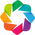

TypeError: unsupported operand type(s) for +: 'QuadMesh' and 'QuadMesh'

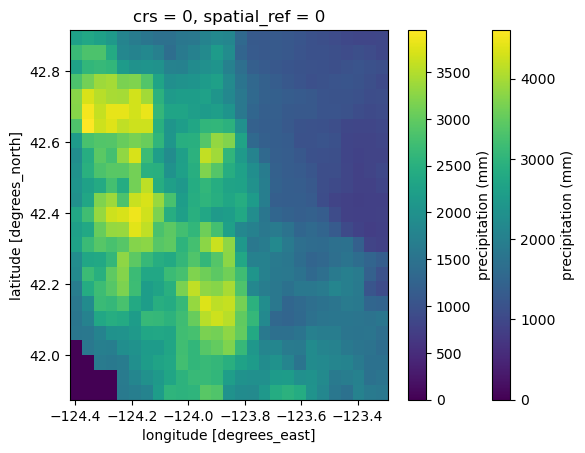

In [20]:
hv.extension('bokeh')
layout = hv.Layout(((ave_annual_pr_das_list[0]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[1]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[2]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[3]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[4]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[6]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[7]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[8]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[9]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[10]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[11]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[12]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[13]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[14]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
    +
    ((ave_annual_pr_das_list[15]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))).cols(4)

layout
# hv.Layout(
#     ((ave_annual_pr_das_list[0]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[1]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[2]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[3]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[4]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[6]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[7]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[8]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[9]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[10]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[11]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[12]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[13]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[14]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     +
#     ((ave_annual_pr_das_list[15]).plot(cbar_kwargs={'label': 'precipitation (mm)'}))
#     ).cols(4)

In [21]:
%store ave_annual_pr_das_list

Stored 'ave_annual_pr_das_list' (list)


# **BREAK - NEED TO COME AND DELETE THE CODE BELOW HERE ONCE WE ARE HAPPY WITH THE CODE ABOVE**

**I feel confident about the code above.**

What all did I try below?

### First, I put the 16 subsetted DataFrames into a dictionary so that I could theoretically loop through them.

In [16]:
# create dictionary of all the subsetted DataFrames
climate_df_dict = {
    'Siskiyou 2050 CanESM2' : siskiyou_2050_can_df,
    'Siskiyou 2050 MIROC-ESM-CHEM' : siskiyou_2050_miroc_df,
    'Siskiyou 2050 MRI-CGCM3' : siskiyou_2050_mri_df,
    'Siskiyou 2050 GFDL-ESM2M' : siskiyou_2050_gfdl_df,
    'Siskiyou 2080 CanESM2' : siskiyou_2080_can_df,
    'Siskiyou 2080 MIROC-ESM-CHEM' : siskiyou_2080_miroc_df,
    'Siskiyou 2080 MRI-CGCM3' : siskiyou_2080_mri_df,
    'Siskiyou 2080 GFDL-ESM2M' : siskiyou_2080_gfdl_df,
    'Padres 2050 CanESM2' : padres_2050_can_df,
    'Padres 2050 MIROC-ESM-CHEM' : padres_2050_miroc_df,
    'Padres 2050 MRI-CGCM3' : padres_2050_mri_df,
    'Padres 2050 GFDL-ESM2M' : padres_2050_gfdl_df,
    'Padres 2080 CanESM2' : padres_2080_can_df,
    'Padres 2080 MIROC-ESM-CHEM' : padres_2080_miroc_df,
    'Padres 2080 MRI-CGCM3' : padres_2080_mri_df,
    'Padres 2080 GFDL-ESM2M' : padres_2080_gfdl_df  
}

# check the keys of the dict were created correctly
climate_df_dict.keys()

dict_keys(['Siskiyou 2050 CanESM2', 'Siskiyou 2050 MIROC-ESM-CHEM', 'Siskiyou 2050 MRI-CGCM3', 'Siskiyou 2050 GFDL-ESM2M', 'Siskiyou 2080 CanESM2', 'Siskiyou 2080 MIROC-ESM-CHEM', 'Siskiyou 2080 MRI-CGCM3', 'Siskiyou 2080 GFDL-ESM2M', 'Padres 2050 CanESM2', 'Padres 2050 MIROC-ESM-CHEM', 'Padres 2050 MRI-CGCM3', 'Padres 2050 GFDL-ESM2M', 'Padres 2080 CanESM2', 'Padres 2080 MIROC-ESM-CHEM', 'Padres 2080 MRI-CGCM3', 'Padres 2080 GFDL-ESM2M'])

### Second, I spent time figuring out how to access the DataArrays in the DataFrames in the climate_df_dict.

In [17]:
# display the dataframe for the key 'Siskiyou 2080 CanESM2'
# without the 'da' column b/c that takes forever to display
display(climate_df_dict.get('Siskiyou 2080 CanESM2').drop('da', axis='columns'))

,site_name,climate_model,date_range
0,SiskiyouForest,CanESM2,2066_2070
4,SiskiyouForest,CanESM2,2071_2075
8,SiskiyouForest,CanESM2,2076_2080
12,SiskiyouForest,CanESM2,2081_2085
16,SiskiyouForest,CanESM2,2086_2090
20,SiskiyouForest,CanESM2,2091_2095


In [18]:
# this displays the each of the 16 dataframes w/o the 'da' column
# for i in climate_df_dict.keys():
#     display(climate_df_dict.get(i).drop('da', axis='columns'))

# Access the dataarray for the first row of each of the climate_df_dict dataframes
for i in climate_df_dict.keys():
    display(climate_df_dict.get(i).da.values[0])

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [19]:
# Access the dataarray for the each row of each of the climate_df_dict dataframes
# should have 96 dataarrays
# it works! 
# with the for statements in this order, one loop through gives the
# DataArray for the first row of each of the climate_df_dict dataframes, so 16 dataarrays.
# If I loop through all 6 times, I get 96 dataarrays.
# What happens if I switch the order of the for statements?
for i in tqdm(climate_df_dict.keys()):
    for num in tqdm(range(6)):
        display(climate_df_dict.get(i).da.values[num])
        break

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (time: 60, lat: 49, lon: 76)> Size: 894kB
[223440 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 392B 34.4 34.44 34.48 34.52 ... 36.31 36.35 36.4
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 608B -121.9 -121.8 -121.8 ... -118.8 -118.8 -118.7
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [20]:
# create a list of the climate_df_dict.keys()
dict_keys = list(climate_df_dict.keys())
dict_keys

['Siskiyou 2050 CanESM2',
 'Siskiyou 2050 MIROC-ESM-CHEM',
 'Siskiyou 2050 MRI-CGCM3',
 'Siskiyou 2050 GFDL-ESM2M',
 'Siskiyou 2080 CanESM2',
 'Siskiyou 2080 MIROC-ESM-CHEM',
 'Siskiyou 2080 MRI-CGCM3',
 'Siskiyou 2080 GFDL-ESM2M',
 'Padres 2050 CanESM2',
 'Padres 2050 MIROC-ESM-CHEM',
 'Padres 2050 MRI-CGCM3',
 'Padres 2050 GFDL-ESM2M',
 'Padres 2080 CanESM2',
 'Padres 2080 MIROC-ESM-CHEM',
 'Padres 2080 MRI-CGCM3',
 'Padres 2080 GFDL-ESM2M']

### Third, once I figured out how to access the DataArrays in the DataFrames in the climate_df_dict w/ the for statements in the correct order, I worked on calculating the average annual precipitation amounts for each 5 year period, AKA the average annual precipitation over each row of the 6 row DataFrame. With the break in the loop below in row 28, I got 6 DataArrays in a list, presumably all for the 'Siskiyou2050 CanESM2' key of the climate_df_dict since that's the first key. 

#### I am unsure of how I could take the break out of the loop below and be able to group each set of 6 DataArrays together so that I could then calculate the average annual precipitation for the whole 30 year period for one DataFrame. How could I tell the loop that the first 6 DataArrays are for 'Siskiyou 2050 CanESM2', the second 6 are for 'Siskiyou 2050 MIROC-ESM-CHEM', the third set of 6 are for 'Siskiyou 2050 MRI-CGCM3', etc so that I could then take the mean of each set of 6? 

##### Do I need to move where the ave_yearly_precip_das = [] is so that that list holds each set of 6? So I'd have 16 ave_yearly_precip_das lists? But then how could I label each list? Maybe I need to use a dictionary? not sure how to make that work.

In [21]:
# Switching the order of the for statements to
# Access the dataarray for the each row of each of the climate_df_dict dataframes
# should have 96 dataarrays
# With the order switched, I now get 6 dataarrays in a list when I put a break in on line 26,
# presumably all for the 'Siskiyou 2050 CanESM2' key.
# Each of the 6 DataArrays represents the ave annual precip of a 5 year period of the Siskisyou 2050 CanESM2 DataFrame
# I think this is what I need b/c now I could use these 6 dataarrays to find the average annual precipitation for the 2036-2065 time period

# empty list to store ave_yearly_precip_das
ave_yearly_precip_das = []
for num in tqdm(range(6)):
    for i in tqdm(climate_df_dict.keys()):

        # access the DataArray for each row of the climate_df_dict DataFrames
        da = climate_df_dict.get(i).da.values[num]

        # add a CRS and set the spatial dimensions of the da
        crs_spatial_da = da.rio.write_crs(4326).rio.set_spatial_dims('lat', 'lon')

        # calculate the total precip for each year of the five year period of the crs_spatial_da
        yearly_precip_da = crs_spatial_da.groupby('time.year').sum()

        # calculate the average annual precip for each year of the 5 year time period
        ave_yearly_precip_da = yearly_precip_da.mean(['year'])

        # add ave_yearly_precip_da to ave_yearly_precip_das list
        ave_yearly_precip_das.append(ave_yearly_precip_da)
        break
ave_yearly_precip_das

### HOW COULD I PUT EACH OF THE 6 DATARRAYS FOR THE 16 KEYS BACK INTO A DICTIONARY SO THAT I CAN FIND THE AVERAGE OVER THE WHOLE TIME PERIOD?
### ALTERNATIVELY, USE THE ABOVE CODE ON EACH OF THE SUBSETTED DATAFRAMES ABOVE TO FIND THE AVE ANNUAL PRECIP FOR EACH 5 YEAR DA
### IN EACH ROW OF THE SUBSETTED DATAFRAMES AND THEN IT MAY BE EASIER TO FIND THE AVE ANNUAL PRECIP FOR EACH 30 YEAR PERIOD

### WHAT IF I ADDED SOMETHING LIKE LINE 22 TO FIND THE 30 YEAR AVERAGE BUT INSTEAD OF MEAN.(['YEAR']) IT WAS MEAN.(['MODEL'])?



  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
 array([[   0.     ,    0.     ,    0.     ,    0.     , 1939.9421 ,
         2008.6213 , 2117.7676 , 2574.5688 , 3053.769  , 3023.8066 ,
         3051.2583 , 3453.1646 , 3368.2417 , 2379.092  , 2251.679  ,
         2239.9656 , 2510.95   , 2853.609  , 2970.7642 , 2867.7952 ,
         2405.228  , 2183.7139 , 1864.6106 , 1776.5625 , 2116.8162 ,
         1958.3151 , 1924.9973 ],
        [   0.     ,    0.     ,    0.     ,    0.     , 1946.9934 ,
         2164.559  , 2361.3984 , 2509.7656 , 2762.7878 , 3018.4026 ,
         3135.6433 , 3127.1973 , 3061.6328 , 2600.2104 , 2395.1797 ,
         2354.3027 , 2349.307  , 2574.868  , 2554.7996 , 2317.0703 ,
         2390.6304 , 2227.9585 , 1915.0424 , 1947.6217 , 2058.817  ,
         1775.8041 , 1826.7797 ],
        [   0.     ,    0.     , 1938.6588 , 1900.4353 , 1943.1031 ,
         2307.5955 , 2551.1157 , 2694.5737 , 2772.0176 , 3227.3853 ,
         3045.9517 , 3109.9792 , 3058.3

### So, because I can't currently figure out how to get my loop above to work for all 16 subsetted DataFrames at once, I'll define the loop as a function and use it on each of the subsetted DataFrames individually.

### Before I do that, I used chatgpt to come up with line 6 of the code below. Line 6 is using the ave_yearly_precip_das list created above, which contains the 6 5-year predicted precip average DataArrays for the 'Siskiyou 2050 CanESM2' DataFrame, to then find the average of those 6 DataArrays, AKA the predicted annual average precip over the 30 year period of 2035 to 2065, AKA 2050.

In [22]:
# calculate the average of all 6 dataarrays for siskiyou 2050 canEsm2
# xr.concat() joins DataArrays in ave_yearly_precip_das along the new dimension 'stack'
# .mean(dim='stack') calculates the ave of al DataArrays along the 'stack' dimension
# now, instead of 6 DataArrays for the Siskiyou CanESM2 2050 DataFrame, each representing the 5 year annual precip ave for each row of the dataframe,
# I have 1 DataArray representing the 30 year annual precipitation ave for the whole Siskiyou CanESM2 2050 DataFrame
ave_annual_precip_sis_can_2050_da = xr.concat(ave_yearly_precip_das, dim='stack').mean(dim='stack')
ave_annual_precip_sis_can_2050_da

<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
array([[   0.     ,    0.     ,    0.     ,    0.     , 1952.9447 ,
        2032.3126 , 2147.47   , 2637.7673 , 3140.83   , 3105.4138 ,
        3137.6006 , 3578.9834 , 3485.7888 , 2448.2295 , 2312.9841 ,
        2296.0469 , 2582.7412 , 2979.5996 , 3096.3906 , 2990.4475 ,
        2502.5588 , 2259.0793 , 1932.8556 , 1832.287  , 2168.911  ,
        2001.5524 , 1964.2653 ],
       [   0.     ,    0.     ,    0.     ,    0.     , 1965.854  ,
        2196.369  , 2411.179  , 2575.1716 , 2834.4023 , 3101.044  ,
        3235.4187 , 3231.2717 , 3163.784  , 2676.8977 , 2458.048  ,
        2408.6758 , 2399.6636 , 2642.8174 , 2651.429  , 2401.986  ,
        2475.108  , 2301.0457 , 1983.476  , 2039.6647 , 2129.43   ,
        1814.4025 , 1866.5381 ],
       [   0.     ,    0.     , 1949.1058 , 1923.6237 , 1971.9346 ,
        2357.5762 , 2616.6736 , 2771.6248 , 2848.424  , 3334.1028 ,
        3139.0918 , 3216.8691 , 3160.738  , 3011.9646 , 2765.947  ,
        2627.1768 , 2333.5264 , 2469.6133 , 2196.3628 , 1870.7777 ,
        2331.2249 , 2273.1956 , 2199.07   , 2165.2017 , 1986.9388 ,
        1807.7119 , 1803.9784 ],
       [   0.     , 1902.7964 , 2023.0663 , 2015.267  , 2330.9822 ,
        2414.3872 , 2583.9326 , 2595.3865 , 2803.1448 , 3312.6028 ,
...
        1140.8472 , 1159.8232 , 1210.9742 , 1226.2501 , 1181.997  ,
        1114.009  , 1048.1633 ],
       [2613.2427 , 3006.1885 , 3066.299  , 3009.1572 , 2502.4695 ,
        2339.241  , 2380.6064 , 2349.83   , 2027.8221 , 1998.1075 ,
        2183.46   , 2277.226  , 2401.985  , 2003.3043 , 1665.8383 ,
        1377.4854 , 1296.8116 , 1256.598  , 1214.5465 , 1185.2555 ,
        1167.5474 , 1153.3317 , 1114.4347 , 1166.4493 , 1190.1956 ,
        1140.4257 , 1115.57   ],
       [3085.0332 , 3273.084  , 3261.8835 , 2766.3887 , 2124.03   ,
        2049.4165 , 2153.848  , 1984.8433 , 1641.2853 , 1868.666  ,
        1981.8744 , 2166.638  , 2496.3857 , 2214.6235 , 1477.1035 ,
        1287.2314 , 1269.6722 , 1288.2115 , 1252.0375 , 1188.6046 ,
        1151.8363 , 1149.2023 , 1112.9171 , 1045.7777 , 1097.0231 ,
        1052.2758 ,  985.1125 ],
       [2563.2915 , 2709.7842 , 2606.1355 , 2442.751  , 2053.2168 ,
        1895.9736 , 1794.9746 , 1703.5934 , 1688.0092 , 1810.9896 ,
        1835.42   , 2036.2529 , 2155.5032 , 2093.2488 , 1539.7875 ,
        1276.7535 , 1261.7261 , 1274.5109 , 1249.4708 , 1207.9242 ,
        1138.6526 , 1109.1627 , 1049.6041 ,  992.4954 ,  954.51276,
         950.5779 ,  972.03076]], dtype=float32)
Coordinates:
  * lat          (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * lon          (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.3
    crs          int64 8B 0
    spatial_ref  int64 8B 0

### Start by focusing on the Siskiyou 2050 climate models:

In [23]:
# Display df w/o DataArray column
display(siskiyou_2050_can_df.drop('da', axis='columns'))
display(siskiyou_2050_miroc_df.drop('da', axis='columns'))
display(siskiyou_2050_mri_df.drop('da', axis='columns'))
display(siskiyou_2050_gfdl_df.drop('da', axis='columns'))

# Pull out the data array for the first row from the CanESM2 df
siskiyou_2050_can_df.da.values[0]

,site_name,climate_model,date_range
0,SiskiyouForest,CanESM2,2036_2040
4,SiskiyouForest,CanESM2,2041_2045
8,SiskiyouForest,CanESM2,2046_2050
12,SiskiyouForest,CanESM2,2051_2055
16,SiskiyouForest,CanESM2,2056_2060
20,SiskiyouForest,CanESM2,2061_2065


,site_name,climate_model,date_range
1,SiskiyouForest,MIROC-ESM-CHEM,2036_2040
5,SiskiyouForest,MIROC-ESM-CHEM,2041_2045
9,SiskiyouForest,MIROC-ESM-CHEM,2046_2050
13,SiskiyouForest,MIROC-ESM-CHEM,2051_2055
17,SiskiyouForest,MIROC-ESM-CHEM,2056_2060
21,SiskiyouForest,MIROC-ESM-CHEM,2061_2065


,site_name,climate_model,date_range
2,SiskiyouForest,MRI-CGCM3,2036_2040
6,SiskiyouForest,MRI-CGCM3,2041_2045
10,SiskiyouForest,MRI-CGCM3,2046_2050
14,SiskiyouForest,MRI-CGCM3,2051_2055
18,SiskiyouForest,MRI-CGCM3,2056_2060
22,SiskiyouForest,MRI-CGCM3,2061_2065


,site_name,climate_model,date_range
3,SiskiyouForest,GFDL-ESM2M,2036_2040
7,SiskiyouForest,GFDL-ESM2M,2041_2045
11,SiskiyouForest,GFDL-ESM2M,2046_2050
15,SiskiyouForest,GFDL-ESM2M,2051_2055
19,SiskiyouForest,GFDL-ESM2M,2056_2060
23,SiskiyouForest,GFDL-ESM2M,2061_2065


<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [24]:
siskiyou_2050_can_df.da.values[3]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2051-01-15 00:00:00 ... 2055-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [25]:
# Define a new loop to calculate the ave annaul precip for each 5 year period in each row of a subsetted DataFrame

# empty list to store ave_yearly_precip_das
ave_annual_precip_5yrs_das = []

# for each of the 6 rows in the DataFrame,
for num in tqdm(range(6)):
    #access the DataArray in that row
    row_da = siskiyou_2050_can_df.da.values[num]

    # add a CRS and set the spatial dimensions of the row_da
    crs_spatial_da = row_da.rio.write_crs(4326).rio.set_spatial_dims('lat', 'lon')

    # calculate the total precip for each year of the five year period of the crs_spatial_da
    yearly_precip_da = crs_spatial_da.groupby('time.year').sum()

    # calculate the average annual precip for each year of the 5 year time period
    ave_yearly_precip_da = yearly_precip_da.mean(['year'])

    # add ave_yearly_precip_da to ave_annual_precip_5yrs_das list
    ave_annual_precip_5yrs_das.append(ave_yearly_precip_da)

ave_annual_precip_5yrs_das

  0%|          | 0/6 [00:00<?, ?it/s]

[<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
 array([[   0.     ,    0.     ,    0.     ,    0.     , 1939.9421 ,
         2008.6213 , 2117.7676 , 2574.5688 , 3053.769  , 3023.8066 ,
         3051.2583 , 3453.1646 , 3368.2417 , 2379.092  , 2251.679  ,
         2239.9656 , 2510.95   , 2853.609  , 2970.7642 , 2867.7952 ,
         2405.228  , 2183.7139 , 1864.6106 , 1776.5625 , 2116.8162 ,
         1958.3151 , 1924.9973 ],
        [   0.     ,    0.     ,    0.     ,    0.     , 1946.9934 ,
         2164.559  , 2361.3984 , 2509.7656 , 2762.7878 , 3018.4026 ,
         3135.6433 , 3127.1973 , 3061.6328 , 2600.2104 , 2395.1797 ,
         2354.3027 , 2349.307  , 2574.868  , 2554.7996 , 2317.0703 ,
         2390.6304 , 2227.9585 , 1915.0424 , 1947.6217 , 2058.817  ,
         1775.8041 , 1826.7797 ],
        [   0.     ,    0.     , 1938.6588 , 1900.4353 , 1943.1031 ,
         2307.5955 , 2551.1157 , 2694.5737 , 2772.0176 , 3227.3853 ,
         3045.9517 , 3109.9792 , 3058.3

In [26]:
# using the new loop above,
# calculate the average of all 6 dataarrays for siskiyou 2050 canEsm2
# xr.concat() joins DataArrays in ave_annual_precip_5yrs_das along the new dimension 'stack'
# .mean(dim='stack') calculates the ave of al DataArrays along the 'stack' dimension
# now, instead of 6 DataArrays for the Siskiyou CanESM2 2050 DataFrame, each representing the 5 year annual precip ave for each row of the dataframe,
# I have 1 DataArray representing the 30 year annual precipitation ave for the whole Siskiyou CanESM2 2050 DataFrame
ave_annual_precip_sis_can_2050_da = xr.concat(ave_annual_precip_5yrs_das, dim='stack').mean(dim='stack')
ave_annual_precip_sis_can_2050_da

<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
array([[   0.     ,    0.     ,    0.     ,    0.     , 1952.9447 ,
        2032.3126 , 2147.47   , 2637.7673 , 3140.83   , 3105.4138 ,
        3137.6006 , 3578.9834 , 3485.7888 , 2448.2295 , 2312.9841 ,
        2296.0469 , 2582.7412 , 2979.5996 , 3096.3906 , 2990.4475 ,
        2502.5588 , 2259.0793 , 1932.8556 , 1832.287  , 2168.911  ,
        2001.5524 , 1964.2653 ],
       [   0.     ,    0.     ,    0.     ,    0.     , 1965.854  ,
        2196.369  , 2411.179  , 2575.1716 , 2834.4023 , 3101.044  ,
        3235.4187 , 3231.2717 , 3163.784  , 2676.8977 , 2458.048  ,
        2408.6758 , 2399.6636 , 2642.8174 , 2651.429  , 2401.986  ,
        2475.108  , 2301.0457 , 1983.476  , 2039.6647 , 2129.43   ,
        1814.4025 , 1866.5381 ],
       [   0.     ,    0.     , 1949.1058 , 1923.6237 , 1971.9346 ,
        2357.5762 , 2616.6736 , 2771.6248 , 2848.424  , 3334.1028 ,
        3139.0918 , 3216.8691 , 3160.738  , 3011.9646 , 2765.947  ,
        2627.1768 , 2333.5264 , 2469.6133 , 2196.3628 , 1870.7777 ,
        2331.2249 , 2273.1956 , 2199.07   , 2165.2017 , 1986.9388 ,
        1807.7119 , 1803.9784 ],
       [   0.     , 1902.7964 , 2023.0663 , 2015.267  , 2330.9822 ,
        2414.3872 , 2583.9326 , 2595.3865 , 2803.1448 , 3312.6028 ,
...
        1140.8472 , 1159.8232 , 1210.9742 , 1226.2501 , 1181.997  ,
        1114.009  , 1048.1633 ],
       [2613.2427 , 3006.1885 , 3066.299  , 3009.1572 , 2502.4695 ,
        2339.241  , 2380.6064 , 2349.83   , 2027.8221 , 1998.1075 ,
        2183.46   , 2277.226  , 2401.985  , 2003.3043 , 1665.8383 ,
        1377.4854 , 1296.8116 , 1256.598  , 1214.5465 , 1185.2555 ,
        1167.5474 , 1153.3317 , 1114.4347 , 1166.4493 , 1190.1956 ,
        1140.4257 , 1115.57   ],
       [3085.0332 , 3273.084  , 3261.8835 , 2766.3887 , 2124.03   ,
        2049.4165 , 2153.848  , 1984.8433 , 1641.2853 , 1868.666  ,
        1981.8744 , 2166.638  , 2496.3857 , 2214.6235 , 1477.1035 ,
        1287.2314 , 1269.6722 , 1288.2115 , 1252.0375 , 1188.6046 ,
        1151.8363 , 1149.2023 , 1112.9171 , 1045.7777 , 1097.0231 ,
        1052.2758 ,  985.1125 ],
       [2563.2915 , 2709.7842 , 2606.1355 , 2442.751  , 2053.2168 ,
        1895.9736 , 1794.9746 , 1703.5934 , 1688.0092 , 1810.9896 ,
        1835.42   , 2036.2529 , 2155.5032 , 2093.2488 , 1539.7875 ,
        1276.7535 , 1261.7261 , 1274.5109 , 1249.4708 , 1207.9242 ,
        1138.6526 , 1109.1627 , 1049.6041 ,  992.4954 ,  954.51276,
         950.5779 ,  972.03076]], dtype=float32)
Coordinates:
  * lat          (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * lon          (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.3
    crs          int64 8B 0
    spatial_ref  int64 8B 0

### For the two previous code cells, do I have to loop through them individually w/ each subsetted DataFrame? I am running into the same issue where I don't know how to use those loops to loop through each subsetted code cell and put the result somewhere that is associated with the name/characteristics of the subsetted DataFrame it came from. I feel like if I'm not able to do that, I'm going to have to run those two loops 16 times which is too much.

### try creating a list to loop through instead of a dictionary

In [ ]:
climate_df_list = [
    siskiyou_2050_can_df,
    siskiyou_2050_miroc_df,
    siskiyou_2050_mri_df,
    siskiyou_2050_gfdl_df,
    siskiyou_2080_can_df,
    siskiyou_2080_miroc_df,
    siskiyou_2080_mri_df,
    siskiyou_2080_gfdl_df,
    padres_2050_can_df,
    padres_2050_miroc_df,
    padres_2050_mri_df,
    padres_2050_gfdl_df,
    padres_2080_can_df,
    padres_2080_miroc_df,
    padres_2080_mri_df,
    padres_2080_gfdl_df
]

In [ ]:
siskiyou_2050_can_df.da.values[0]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2036-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [32]:
# Use new loop to calculate the ave annaul precip for each 5 year period in each row of a subsetted DataFrame

# empty list to store ave_yearly_precip_das
ave_annual_precip_5yrs_das = []

# for each of the 6 rows in the DataFrame,
for num in tqdm(range(6)):
    #access the DataArray in that row
    row_da = siskiyou_2050_can_df.da.values[num]

    # add a CRS and set the spatial dimensions of the row_da
    crs_spatial_da = row_da.rio.write_crs(4326).rio.set_spatial_dims('lat', 'lon')

    # calculate the total precip for each year of the five year period of the crs_spatial_da
    yearly_precip_da = crs_spatial_da.groupby('time.year').sum()

    # calculate the average annual precip for each year of the 5 year time period
    ave_yearly_precip_da = yearly_precip_da.mean(['year'])

    # add ave_yearly_precip_da to ave_annual_precip_5yrs_das list
    ave_annual_precip_5yrs_das.append(ave_yearly_precip_da)

ave_annual_precip_5yrs_das

  0%|          | 0/6 [00:00<?, ?it/s]

[<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
 array([[   0.     ,    0.     ,    0.     ,    0.     , 1939.9421 ,
         2008.6213 , 2117.7676 , 2574.5688 , 3053.769  , 3023.8066 ,
         3051.2583 , 3453.1646 , 3368.2417 , 2379.092  , 2251.679  ,
         2239.9656 , 2510.95   , 2853.609  , 2970.7642 , 2867.7952 ,
         2405.228  , 2183.7139 , 1864.6106 , 1776.5625 , 2116.8162 ,
         1958.3151 , 1924.9973 ],
        [   0.     ,    0.     ,    0.     ,    0.     , 1946.9934 ,
         2164.559  , 2361.3984 , 2509.7656 , 2762.7878 , 3018.4026 ,
         3135.6433 , 3127.1973 , 3061.6328 , 2600.2104 , 2395.1797 ,
         2354.3027 , 2349.307  , 2574.868  , 2554.7996 , 2317.0703 ,
         2390.6304 , 2227.9585 , 1915.0424 , 1947.6217 , 2058.817  ,
         1775.8041 , 1826.7797 ],
        [   0.     ,    0.     , 1938.6588 , 1900.4353 , 1943.1031 ,
         2307.5955 , 2551.1157 , 2694.5737 , 2772.0176 , 3227.3853 ,
         3045.9517 , 3109.9792 , 3058.3

In [33]:
# using the new loop above,
# calculate the average of all 6 dataarrays for siskiyou 2050 canEsm2
# xr.concat() joins DataArrays in ave_annual_precip_5yrs_das along the new dimension 'stack'
# .mean(dim='stack') calculates the ave of al DataArrays along the 'stack' dimension
# now, instead of 6 DataArrays for the Siskiyou CanESM2 2050 DataFrame, each representing the 5 year annual precip ave for each row of the dataframe,
# I have 1 DataArray representing the 30 year annual precipitation ave for the whole Siskiyou CanESM2 2050 DataFrame
ave_annual_precip_sis_can_2050_da = xr.concat(ave_annual_precip_5yrs_das, dim='stack').mean(dim='stack')
ave_annual_precip_sis_can_2050_da

<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
array([[   0.     ,    0.     ,    0.     ,    0.     , 1952.9447 ,
        2032.3126 , 2147.47   , 2637.7673 , 3140.83   , 3105.4138 ,
        3137.6006 , 3578.9834 , 3485.7888 , 2448.2295 , 2312.9841 ,
        2296.0469 , 2582.7412 , 2979.5996 , 3096.3906 , 2990.4475 ,
        2502.5588 , 2259.0793 , 1932.8556 , 1832.287  , 2168.911  ,
        2001.5524 , 1964.2653 ],
       [   0.     ,    0.     ,    0.     ,    0.     , 1965.854  ,
        2196.369  , 2411.179  , 2575.1716 , 2834.4023 , 3101.044  ,
        3235.4187 , 3231.2717 , 3163.784  , 2676.8977 , 2458.048  ,
        2408.6758 , 2399.6636 , 2642.8174 , 2651.429  , 2401.986  ,
        2475.108  , 2301.0457 , 1983.476  , 2039.6647 , 2129.43   ,
        1814.4025 , 1866.5381 ],
       [   0.     ,    0.     , 1949.1058 , 1923.6237 , 1971.9346 ,
        2357.5762 , 2616.6736 , 2771.6248 , 2848.424  , 3334.1028 ,
        3139.0918 , 3216.8691 , 3160.738  , 3011.9646 , 2765.947  ,
        2627.1768 , 2333.5264 , 2469.6133 , 2196.3628 , 1870.7777 ,
        2331.2249 , 2273.1956 , 2199.07   , 2165.2017 , 1986.9388 ,
        1807.7119 , 1803.9784 ],
       [   0.     , 1902.7964 , 2023.0663 , 2015.267  , 2330.9822 ,
        2414.3872 , 2583.9326 , 2595.3865 , 2803.1448 , 3312.6028 ,
...
        1140.8472 , 1159.8232 , 1210.9742 , 1226.2501 , 1181.997  ,
        1114.009  , 1048.1633 ],
       [2613.2427 , 3006.1885 , 3066.299  , 3009.1572 , 2502.4695 ,
        2339.241  , 2380.6064 , 2349.83   , 2027.8221 , 1998.1075 ,
        2183.46   , 2277.226  , 2401.985  , 2003.3043 , 1665.8383 ,
        1377.4854 , 1296.8116 , 1256.598  , 1214.5465 , 1185.2555 ,
        1167.5474 , 1153.3317 , 1114.4347 , 1166.4493 , 1190.1956 ,
        1140.4257 , 1115.57   ],
       [3085.0332 , 3273.084  , 3261.8835 , 2766.3887 , 2124.03   ,
        2049.4165 , 2153.848  , 1984.8433 , 1641.2853 , 1868.666  ,
        1981.8744 , 2166.638  , 2496.3857 , 2214.6235 , 1477.1035 ,
        1287.2314 , 1269.6722 , 1288.2115 , 1252.0375 , 1188.6046 ,
        1151.8363 , 1149.2023 , 1112.9171 , 1045.7777 , 1097.0231 ,
        1052.2758 ,  985.1125 ],
       [2563.2915 , 2709.7842 , 2606.1355 , 2442.751  , 2053.2168 ,
        1895.9736 , 1794.9746 , 1703.5934 , 1688.0092 , 1810.9896 ,
        1835.42   , 2036.2529 , 2155.5032 , 2093.2488 , 1539.7875 ,
        1276.7535 , 1261.7261 , 1274.5109 , 1249.4708 , 1207.9242 ,
        1138.6526 , 1109.1627 , 1049.6041 ,  992.4954 ,  954.51276,
         950.5779 ,  972.03076]], dtype=float32)
Coordinates:
  * lat          (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * lon          (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.3
    crs          int64 8B 0
    spatial_ref  int64 8B 0

In [34]:
# Use new loop to calculate the ave annaul precip for each 5 year period in each row of a subsetted DataFrame

# empty list to store ave_yearly_precip_das
siskiyou_2050_miroc_ave_annual_precip_5yrs_das = []

# for each of the 6 rows in the DataFrame,
for num in tqdm(range(6)):
    #access the DataArray in that row
    row_da = siskiyou_2050_miroc_df.da.values[num]

    # add a CRS and set the spatial dimensions of the row_da
    crs_spatial_da = row_da.rio.write_crs(4326).rio.set_spatial_dims('lat', 'lon')

    # calculate the total precip for each year of the five year period of the crs_spatial_da
    yearly_precip_da = crs_spatial_da.groupby('time.year').sum()

    # calculate the average annual precip for each year of the 5 year time period
    ave_yearly_precip_da = yearly_precip_da.mean(['year'])

    # add ave_yearly_precip_da to siskiyou_2050_miroc_ave_annual_precip_5yrs_das list
    siskiyou_2050_miroc_ave_annual_precip_5yrs_das.append(ave_yearly_precip_da)

siskiyou_2050_miroc_ave_annual_precip_5yrs_das

  0%|          | 0/6 [00:00<?, ?it/s]

[<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
 array([[   0.     ,    0.     ,    0.     ,    0.     , 1588.8136 ,
         1651.4039 , 1724.5798 , 2092.768  , 2465.2263 , 2436.0264 ,
         2463.0242 , 2812.775  , 2738.4685 , 1928.8541 , 1814.6215 ,
         1795.9948 , 2023.0785 , 2342.2297 , 2426.4395 , 2337.8618 ,
         1950.6963 , 1758.5576 , 1491.2007 , 1388.3005 , 1626.3718 ,
         1506.2764 , 1477.8572 ],
        [   0.     ,    0.     ,    0.     ,    0.     , 1610.4517 ,
         1782.8756 , 1938.0547 , 2058.9512 , 2243.9636 , 2451.9468 ,
         2562.698  , 2557.4668 , 2504.7551 , 2122.121  , 1938.4756 ,
         1890.9502 , 1874.916  , 2059.891  , 2076.7456 , 1884.4622 ,
         1928.5857 , 1806.7617 , 1550.5391 , 1589.6931 , 1636.112  ,
         1386.0394 , 1421.007  ],
        [   0.     ,    0.     , 1586.7922 , 1581.7637 , 1618.8464 ,
         1926.6082 , 2118.5242 , 2233.8975 , 2281.5176 , 2662.7104 ,
         2505.0574 , 2568.479  , 2523.8

In [35]:
ave_annual_precip_sis_miroc_2050_da = xr.concat(siskiyou_2050_miroc_ave_annual_precip_5yrs_das, dim='stack').mean(dim='stack')
ave_annual_precip_sis_miroc_2050_da

<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
array([[   0.     ,    0.     ,    0.     ,    0.     , 1612.6434 ,
        1678.459  , 1767.2401 , 2162.8972 , 2562.3596 , 2533.9758 ,
        2561.954  , 2925.328  , 2853.1458 , 2003.4591 , 1889.0038 ,
        1874.9711 , 2109.6458 , 2432.6865 , 2518.973  , 2431.5088 ,
        2023.5162 , 1821.3843 , 1560.5187 , 1474.4882 , 1736.5023 ,
        1605.9039 , 1581.7422 ],
       [   0.     ,    0.     ,    0.     ,    0.     , 1630.2089 ,
        1818.2091 , 1988.649  , 2119.821  , 2324.2366 , 2544.0647 ,
        2658.236  , 2656.876  , 2602.7598 , 2199.9626 , 2015.4838 ,
        1971.4438 , 1962.1083 , 2157.505  , 2160.8586 , 1958.5753 ,
        2007.7697 , 1871.0107 , 1607.772  , 1652.248  , 1720.7919 ,
        1468.0557 , 1515.32   ],
       [   0.     ,    0.     , 1623.0516 , 1597.8607 , 1638.4879 ,
        1957.671  , 2162.0525 , 2287.6458 , 2346.7676 , 2747.1562 ,
        2590.7405 , 2654.828  , 2608.7068 , 2483.046  , 2273.4233 ,
        2152.0684 , 1901.8286 , 2014.6588 , 1791.1725 , 1526.4813 ,
        1896.1293 , 1859.9438 , 1794.2719 , 1763.829  , 1615.653  ,
        1476.8995 , 1475.4186 ],
       [   0.     , 1584.4756 , 1684.2719 , 1675.9531 , 1942.8104 ,
        2011.4946 , 2144.1995 , 2149.801  , 2317.1575 , 2743.7952 ,
...
         969.978  ,  986.8986 , 1030.2687 , 1041.2025 , 1003.91534,
         947.62134,  891.1971 ],
       [2252.8127 , 2593.1377 , 2642.8662 , 2592.0144 , 2155.6106 ,
        2010.61   , 2041.119  , 2013.9985 , 1749.1592 , 1721.9117 ,
        1889.3429 , 1962.1058 , 2050.213  , 1712.7533 , 1424.5835 ,
        1180.6536 , 1114.2435 , 1078.0812 , 1040.6012 , 1013.26935,
         994.94037,  982.76654,  952.0564 ,  998.977  , 1020.5362 ,
         977.28094,  951.2979 ],
       [2676.3215 , 2835.2415 , 2821.82   , 2393.9602 , 1831.3375 ,
        1763.3981 , 1847.2051 , 1706.0353 , 1408.3282 , 1615.691  ,
        1718.1201 , 1877.2764 , 2145.53   , 1900.0288 , 1270.6139 ,
        1110.5659 , 1094.3075 , 1109.3717 , 1076.225  , 1017.8659 ,
         984.1643 ,  981.5437 ,  952.4107 ,  896.9274 ,  944.2321 ,
         906.2203 ,  846.90424],
       [2226.4065 , 2352.4973 , 2259.4304 , 2118.5105 , 1776.7164 ,
        1635.4667 , 1543.5781 , 1464.7128 , 1451.8658 , 1562.8848 ,
        1588.1719 , 1758.7974 , 1858.417  , 1808.6    , 1335.8253 ,
        1105.8337 , 1087.833  , 1099.829  , 1074.3143 , 1034.6367 ,
         972.19434,  948.3611 ,  897.6135 ,  850.64746,  819.9748 ,
         817.2646 ,  835.5159 ]], dtype=float32)
Coordinates:
  * lat          (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * lon          (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.3
    crs          int64 8B 0
    spatial_ref  int64 8B 0

In [36]:
# Use new loop to calculate the ave annaul precip for each 5 year period in each row of a subsetted DataFrame

# empty list to store ave_yearly_precip_das
siskiyou_2050_mri_ave_annual_precip_5yrs_das = []

# for each of the 6 rows in the DataFrame,
for num in tqdm(range(6)):
    #access the DataArray in that row
    row_da = siskiyou_2050_mri_df.da.values[num]

    # add a CRS and set the spatial dimensions of the row_da
    crs_spatial_da = row_da.rio.write_crs(4326).rio.set_spatial_dims('lat', 'lon')

    # calculate the total precip for each year of the five year period of the crs_spatial_da
    yearly_precip_da = crs_spatial_da.groupby('time.year').sum()

    # calculate the average annual precip for each year of the 5 year time period
    ave_yearly_precip_da = yearly_precip_da.mean(['year'])

    # add ave_yearly_precip_da to siskiyou_2050_mri_ave_annual_precip_5yrs_das list
    siskiyou_2050_mri_ave_annual_precip_5yrs_das.append(ave_yearly_precip_da)

siskiyou_2050_mri_ave_annual_precip_5yrs_das

  0%|          | 0/6 [00:00<?, ?it/s]

[<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
 array([[   0.     ,    0.     ,    0.     ,    0.     , 1847.2262 ,
         1922.1198 , 2028.0305 , 2484.4495 , 2940.494  , 2889.817  ,
         2908.7358 , 3308.4062 , 3217.7463 , 2266.541  , 2135.6528 ,
         2122.5435 , 2375.8481 , 2738.778  , 2833.6304 , 2744.539  ,
         2292.3994 , 2058.3752 , 1754.4772 , 1660.072  , 1951.441  ,
         1793.0481 , 1758.0795 ],
        [   0.     ,    0.     ,    0.     ,    0.     , 1856.2037 ,
         2076.4915 , 2279.253  , 2417.5728 , 2641.1445 , 2881.7075 ,
         2995.371  , 2977.795  , 2913.6558 , 2471.4575 , 2261.6558 ,
         2217.9714 , 2214.3125 , 2437.0825 , 2433.2192 , 2215.9595 ,
         2278.003  , 2105.7388 , 1803.3168 , 1857.8875 , 1932.4525 ,
         1630.3359 , 1664.6443 ],
        [   0.     ,    0.     , 1856.1947 , 1821.1927 , 1862.1448 ,
         2226.7249 , 2461.96   , 2607.5393 , 2670.6226 , 3093.6665 ,
         2909.1646 , 2963.241  , 2910.7

In [37]:
ave_annual_precip_sis_mri_2050_da = xr.concat(siskiyou_2050_mri_ave_annual_precip_5yrs_das, dim='stack').mean(dim='stack')
ave_annual_precip_sis_mri_2050_da

<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
array([[   0.     ,    0.     ,    0.     ,    0.     , 1888.2838 ,
        1968.9277 , 2076.711  , 2549.0964 , 3019.5588 , 2973.0046 ,
        2997.9893 , 3412.654  , 3322.6765 , 2337.198  , 2207.6946 ,
        2190.0684 , 2462.383  , 2840.3767 , 2951.1223 , 2844.1963 ,
        2373.87   , 2137.4778 , 1825.1718 , 1729.0502 , 2045.4755 ,
        1885.458  , 1849.359  ],
       [   0.     ,    0.     ,    0.     ,    0.     , 1901.9462 ,
        2125.6614 , 2332.387  , 2483.6882 , 2721.1084 , 2970.6492 ,
        3093.0457 , 3081.4387 , 3017.7566 , 2557.4807 , 2344.926  ,
        2297.5703 , 2290.8674 , 2525.301  , 2529.323  , 2284.698  ,
        2341.5771 , 2178.511  , 1870.6143 , 1920.4664 , 2005.5513 ,
        1709.4943 , 1757.6383 ],
       [   0.     ,    0.     , 1887.1929 , 1856.7689 , 1904.4017 ,
        2285.2878 , 2529.8328 , 2673.3943 , 2741.1204 , 3196.7761 ,
        3009.473  , 3077.3848 , 3024.2312 , 2881.1433 , 2640.6775 ,
        2508.054  , 2223.0706 , 2358.1096 , 2094.068  , 1771.2074 ,
        2206.4548 , 2157.077  , 2082.4424 , 2044.2963 , 1869.7617 ,
        1700.841  , 1692.0942 ],
       [   0.     , 1830.7533 , 1957.1544 , 1944.4811 , 2256.8582 ,
        2341.2551 , 2500.7988 , 2504.139  , 2699.0583 , 3184.795  ,
...
        1085.681  , 1105.023  , 1155.3163 , 1169.5719 , 1123.5157 ,
        1054.922  ,  986.4258 ],
       [2537.125  , 2917.8606 , 2976.0544 , 2924.889  , 2434.7786 ,
        2273.816  , 2311.4624 , 2281.1711 , 1968.9967 , 1936.5697 ,
        2122.4827 , 2209.203  , 2314.3875 , 1928.1901 , 1594.911  ,
        1321.81   , 1244.4259 , 1204.891  , 1162.0851 , 1133.1578 ,
        1112.1986 , 1097.6085 , 1062.5018 , 1113.1625 , 1133.685  ,
        1082.8573 , 1051.8246 ],
       [3002.382  , 3182.7012 , 3171.379  , 2694.3757 , 2062.4495 ,
        1990.6133 , 2089.8738 , 1923.3893 , 1584.9764 , 1810.4108 ,
        1925.1107 , 2104.1902 , 2409.8567 , 2132.3499 , 1419.715  ,
        1236.5883 , 1217.1793 , 1233.6066 , 1198.7871 , 1133.9313 ,
        1096.8295 , 1093.7183 , 1059.8544 ,  994.84033, 1043.6464 ,
         999.5271 ,  932.4222 ],
       [2491.1824 , 2632.7036 , 2532.4001 , 2377.0432 , 1995.106  ,
        1841.0752 , 1737.642  , 1647.4012 , 1628.4332 , 1748.7682 ,
        1775.605  , 1971.6754 , 2076.7402 , 2016.6705 , 1482.1168 ,
        1225.582  , 1207.4489 , 1218.5607 , 1193.4553 , 1151.2975 ,
        1082.6495 , 1054.156  ,  996.62964,  941.695  ,  904.5203 ,
         900.03046,  918.48114]], dtype=float32)
Coordinates:
  * lat          (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * lon          (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.3
    crs          int64 8B 0
    spatial_ref  int64 8B 0

In [38]:
# Use new loop to calculate the ave annaul precip for each 5 year period in each row of a subsetted DataFrame

# empty list to store ave_yearly_precip_das
siskiyou_2050_gfdl_ave_annual_precip_5yrs_das = []

# for each of the 6 rows in the DataFrame,
for num in tqdm(range(6)):
    #access the DataArray in that row
    row_da = siskiyou_2050_gfdl_df.da.values[num]

    # add a CRS and set the spatial dimensions of the row_da
    crs_spatial_da = row_da.rio.write_crs(4326).rio.set_spatial_dims('lat', 'lon')

    # calculate the total precip for each year of the five year period of the crs_spatial_da
    yearly_precip_da = crs_spatial_da.groupby('time.year').sum()

    # calculate the average annual precip for each year of the 5 year time period
    ave_yearly_precip_da = yearly_precip_da.mean(['year'])

    # add ave_yearly_precip_da to siskiyou_2050_gfdl_ave_annual_precip_5yrs_das list
    siskiyou_2050_gfdl_ave_annual_precip_5yrs_das.append(ave_yearly_precip_da)

siskiyou_2050_gfdl_ave_annual_precip_5yrs_das

  0%|          | 0/6 [00:00<?, ?it/s]

[<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
 array([[   0.     ,    0.     ,    0.     ,    0.     , 1923.1023 ,
         2006.7914 , 2111.878  , 2595.51   , 3083.5103 , 3034.6997 ,
         3083.8462 , 3527.9973 , 3452.3242 , 2409.274  , 2275.6448 ,
         2261.2368 , 2550.871  , 2962.151  , 3057.8762 , 2956.409  ,
         2474.3472 , 2220.009  , 1904.8582 , 1789.6302 , 2100.6523 ,
         1941.1904 , 1912.903  ],
        [   0.     ,    0.     ,    0.     ,    0.     , 1939.4153 ,
         2172.1934 , 2377.0596 , 2530.0293 , 2778.3457 , 3047.0527 ,
         3186.979  , 3187.4216 , 3129.173  , 2638.1926 , 2413.8801 ,
         2369.5994 , 2361.895  , 2606.4019 , 2626.0957 , 2380.4397 ,
         2439.3801 , 2275.2036 , 1957.0713 , 2021.8815 , 2094.8345 ,
         1777.9479 , 1842.3441 ],
        [   0.     ,    0.     , 1908.2786 , 1902.1168 , 1950.6957 ,
         2341.759  , 2591.7563 , 2735.1626 , 2797.8816 , 3284.9614 ,
         3101.609  , 3181.9824 , 3127.5

In [ ]:
ave_annual_precip_sis_gfdl_2050_da = xr.concat(siskiyou_2050_gfdl_ave_annual_precip_5yrs_das, dim='stack').mean(dim='stack')
ave_annual_precip_sis_gfdl_2050_da

<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
array([[   0.     ,    0.     ,    0.     ,    0.     , 1747.6055 ,
        1823.4054 , 1928.8715 , 2373.738  , 2824.8184 , 2795.9358 ,
        2830.9502 , 3236.9514 , 3158.3877 , 2212.1838 , 2089.7827 ,
        2076.218  , 2337.3887 , 2697.4905 , 2799.3772 , 2705.9895 ,
        2259.8342 , 2033.4159 , 1743.4381 , 1654.7897 , 1964.7378 ,
        1814.1602 , 1790.0626 ],
       [   0.     ,    0.     ,    0.     ,    0.     , 1762.7936 ,
        1974.1763 , 2168.6328 , 2319.13   , 2547.733  , 2794.9277 ,
        2925.2559 , 2925.4104 , 2865.8867 , 2421.368  , 2221.8674 ,
        2178.111  , 2169.4197 , 2399.5544 , 2404.9753 , 2182.9563 ,
        2240.1858 , 2083.828  , 1791.3716 , 1845.0197 , 1932.3843 ,
        1651.5013 , 1706.0353 ],
       [   0.     ,    0.     , 1742.4088 , 1722.1974 , 1767.9369 ,
        2121.0635 , 2355.8218 , 2497.5273 , 2563.3037 , 3006.1514 ,
        2839.511  , 2914.075  , 2864.6768 , 2731.2551 , 2505.5496 ,
        2378.952  , 2106.7107 , 2240.71   , 1995.6904 , 1694.7013 ,
        2114.6096 , 2063.3208 , 1995.7675 , 1966.1206 , 1802.5719 ,
        1645.3551 , 1648.9982 ],
       [   0.     , 1698.149  , 1806.2789 , 1800.8661 , 2097.4414 ,
        2175.033  , 2327.8652 , 2339.1023 , 2526.2976 , 2996.822  ,
...
        1057.8673 , 1076.9902 , 1128.4265 , 1143.4197 , 1101.0409 ,
        1036.7148 ,  971.00854],
       [2413.3828 , 2776.5393 , 2832.347  , 2783.9504 , 2315.9238 ,
        2162.738  , 2205.3691 , 2182.4    , 1886.0912 , 1859.7528 ,
        2039.6595 , 2126.678  , 2237.684  , 1864.914  , 1545.7017 ,
        1280.225  , 1207.9349 , 1170.915  , 1130.944  , 1103.9099 ,
        1084.9923 , 1071.9777 , 1036.6858 , 1088.235  , 1112.308  ,
        1063.1964 , 1033.7992 ],
       [2858.53   , 3031.2712 , 3021.6992 , 2569.327  , 1967.6447 ,
        1899.0557 , 1996.0605 , 1842.9312 , 1521.5133 , 1740.0283 ,
        1851.663  , 2025.8026 , 2333.2886 , 2065.7441 , 1375.7373 ,
        1200.7982 , 1184.4061 , 1201.2213 , 1167.8134 , 1106.8322 ,
        1072.6035 , 1071.125  , 1037.3037 ,  973.9101 , 1023.0257 ,
         980.8851 ,  916.3752 ],
       [2380.2146 , 2515.762  , 2419.9883 , 2269.8662 , 1911.3673 ,
        1764.3969 , 1669.5446 , 1583.1836 , 1570.2252 , 1686.3788 ,
        1712.4454 , 1905.5245 , 2012.1881 , 1952.4452 , 1440.481  ,
        1192.9965 , 1178.0168 , 1189.9188 , 1165.5093 , 1126.3228 ,
        1061.3452 , 1035.0001 ,  977.0454 ,  925.3821 ,  888.3171 ,
         884.22314,  903.3266 ]], dtype=float32)
Coordinates:
  * lat          (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * lon          (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.3
    crs          int64 8B 0
    spatial_ref  int64 8B 0

In [40]:
# Use new loop to calculate the ave annaul precip for each 5 year period in each row of a subsetted DataFrame

# empty list to store ave_yearly_precip_das
siskiyou_2050_gfdl_ave_annual_precip_5yrs_das = []

# for each of the 6 rows in the DataFrame,
for num in tqdm(range(6)):
    #access the DataArray in that row
    row_da = siskiyou_2050_gfdl_df.da.values[num]

    # add a CRS and set the spatial dimensions of the row_da
    crs_spatial_da = row_da.rio.write_crs(4326).rio.set_spatial_dims('lat', 'lon')

    # calculate the total precip for each year of the five year period of the crs_spatial_da
    yearly_precip_da = crs_spatial_da.groupby('time.year').sum()

    # calculate the average annual precip for each year of the 5 year time period
    ave_yearly_precip_da = yearly_precip_da.mean(['year'])

    # add ave_yearly_precip_da to siskiyou_2050_gfdl_ave_annual_precip_5yrs_das list
    siskiyou_2050_gfdl_ave_annual_precip_5yrs_das.append(ave_yearly_precip_da)

ave_annual_precip_sis_gfdl_2050_da = xr.concat(siskiyou_2050_gfdl_ave_annual_precip_5yrs_das, dim='stack').mean(dim='stack')
ave_annual_precip_sis_gfdl_2050_da

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
array([[   0.     ,    0.     ,    0.     ,    0.     , 1747.6055 ,
        1823.4054 , 1928.8715 , 2373.738  , 2824.8184 , 2795.9358 ,
        2830.9502 , 3236.9514 , 3158.3877 , 2212.1838 , 2089.7827 ,
        2076.218  , 2337.3887 , 2697.4905 , 2799.3772 , 2705.9895 ,
        2259.8342 , 2033.4159 , 1743.4381 , 1654.7897 , 1964.7378 ,
        1814.1602 , 1790.0626 ],
       [   0.     ,    0.     ,    0.     ,    0.     , 1762.7936 ,
        1974.1763 , 2168.6328 , 2319.13   , 2547.733  , 2794.9277 ,
        2925.2559 , 2925.4104 , 2865.8867 , 2421.368  , 2221.8674 ,
        2178.111  , 2169.4197 , 2399.5544 , 2404.9753 , 2182.9563 ,
        2240.1858 , 2083.828  , 1791.3716 , 1845.0197 , 1932.3843 ,
        1651.5013 , 1706.0353 ],
       [   0.     ,    0.     , 1742.4088 , 1722.1974 , 1767.9369 ,
        2121.0635 , 2355.8218 , 2497.5273 , 2563.3037 , 3006.1514 ,
        2839.511  , 2914.075  , 2864.6768 , 2731.2551 , 2505.5496 ,
        2378.952  , 2106.7107 , 2240.71   , 1995.6904 , 1694.7013 ,
        2114.6096 , 2063.3208 , 1995.7675 , 1966.1206 , 1802.5719 ,
        1645.3551 , 1648.9982 ],
       [   0.     , 1698.149  , 1806.2789 , 1800.8661 , 2097.4414 ,
        2175.033  , 2327.8652 , 2339.1023 , 2526.2976 , 2996.822  ,
...
        1057.8673 , 1076.9902 , 1128.4265 , 1143.4197 , 1101.0409 ,
        1036.7148 ,  971.00854],
       [2413.3828 , 2776.5393 , 2832.347  , 2783.9504 , 2315.9238 ,
        2162.738  , 2205.3691 , 2182.4    , 1886.0912 , 1859.7528 ,
        2039.6595 , 2126.678  , 2237.684  , 1864.914  , 1545.7017 ,
        1280.225  , 1207.9349 , 1170.915  , 1130.944  , 1103.9099 ,
        1084.9923 , 1071.9777 , 1036.6858 , 1088.235  , 1112.308  ,
        1063.1964 , 1033.7992 ],
       [2858.53   , 3031.2712 , 3021.6992 , 2569.327  , 1967.6447 ,
        1899.0557 , 1996.0605 , 1842.9312 , 1521.5133 , 1740.0283 ,
        1851.663  , 2025.8026 , 2333.2886 , 2065.7441 , 1375.7373 ,
        1200.7982 , 1184.4061 , 1201.2213 , 1167.8134 , 1106.8322 ,
        1072.6035 , 1071.125  , 1037.3037 ,  973.9101 , 1023.0257 ,
         980.8851 ,  916.3752 ],
       [2380.2146 , 2515.762  , 2419.9883 , 2269.8662 , 1911.3673 ,
        1764.3969 , 1669.5446 , 1583.1836 , 1570.2252 , 1686.3788 ,
        1712.4454 , 1905.5245 , 2012.1881 , 1952.4452 , 1440.481  ,
        1192.9965 , 1178.0168 , 1189.9188 , 1165.5093 , 1126.3228 ,
        1061.3452 , 1035.0001 ,  977.0454 ,  925.3821 ,  888.3171 ,
         884.22314,  903.3266 ]], dtype=float32)
Coordinates:
  * lat          (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * lon          (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.3
    crs          int64 8B 0
    spatial_ref  int64 8B 0

### Define a function to find the predicted average annual precipitation over each 30 year time period represented by each subsetted DataFrame.

THESE NEXT THREE CODE CELLS WORK!

In [44]:
def ave_annual_pr(df_len, df):
    """
    Calculate the predicted average annual precipitation
    for the DataArrays in a DataFrame.

    Parameters
    ----------
    df_len : int
        the number of rows in the DataFrame
    df : DataFrame
        the DataFrame that houses the DataArrays

    Returns
    -------
    df_ave_annual_precip_da: DataArray
        A DataArray with the predicted average annual precipitation
        over the total time period of the DataFrame
    """

    # empty list to store the average annual precipitation
    # for the DataArray in each row of a DataFrame
    row_ave_annual_precip_das = []

    # for each of the rows in the DataFrame,
    for num in tqdm(range(df_len)):
        #access the DataArray in that row
        row_da = df.da.values[num]

        # add a CRS and set the spatial dimensions of the row_da
        crs_spatial_da = row_da.rio.write_crs(4326).rio.set_spatial_dims('lat', 'lon')

        # calculate the total precip for each individual year
        # in the time period of the crs_spatial_da
        annual_precip_da = crs_spatial_da.groupby('time.year').sum()

        # calculate the average annual precip for 
        # the total time period of the row_da
        ave_annual_precip_da = annual_precip_da.mean(['year'])

        # add ave_annual_precip_da to row_ave_annual_precip_das list
        row_ave_annual_precip_das.append(ave_annual_precip_da)

    # calculate the average annual precip for the
    # total time period of the whole DataFrame
    df_ave_annual_precip_da = (
        xr.concat(row_ave_annual_precip_das, dim='stack')
        .mean(dim='stack'))
    
    return df_ave_annual_precip_da

In [45]:
ave_annual_precip_sis_gfdl_2050_da = ave_annual_pr(6, siskiyou_2050_gfdl_df)
ave_annual_precip_sis_gfdl_2050_da

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
array([[   0.     ,    0.     ,    0.     ,    0.     , 1747.6055 ,
        1823.4054 , 1928.8715 , 2373.738  , 2824.8184 , 2795.9358 ,
        2830.9502 , 3236.9514 , 3158.3877 , 2212.1838 , 2089.7827 ,
        2076.218  , 2337.3887 , 2697.4905 , 2799.3772 , 2705.9895 ,
        2259.8342 , 2033.4159 , 1743.4381 , 1654.7897 , 1964.7378 ,
        1814.1602 , 1790.0626 ],
       [   0.     ,    0.     ,    0.     ,    0.     , 1762.7936 ,
        1974.1763 , 2168.6328 , 2319.13   , 2547.733  , 2794.9277 ,
        2925.2559 , 2925.4104 , 2865.8867 , 2421.368  , 2221.8674 ,
        2178.111  , 2169.4197 , 2399.5544 , 2404.9753 , 2182.9563 ,
        2240.1858 , 2083.828  , 1791.3716 , 1845.0197 , 1932.3843 ,
        1651.5013 , 1706.0353 ],
       [   0.     ,    0.     , 1742.4088 , 1722.1974 , 1767.9369 ,
        2121.0635 , 2355.8218 , 2497.5273 , 2563.3037 , 3006.1514 ,
        2839.511  , 2914.075  , 2864.6768 , 2731.2551 , 2505.5496 ,
        2378.952  , 2106.7107 , 2240.71   , 1995.6904 , 1694.7013 ,
        2114.6096 , 2063.3208 , 1995.7675 , 1966.1206 , 1802.5719 ,
        1645.3551 , 1648.9982 ],
       [   0.     , 1698.149  , 1806.2789 , 1800.8661 , 2097.4414 ,
        2175.033  , 2327.8652 , 2339.1023 , 2526.2976 , 2996.822  ,
...
        1057.8673 , 1076.9902 , 1128.4265 , 1143.4197 , 1101.0409 ,
        1036.7148 ,  971.00854],
       [2413.3828 , 2776.5393 , 2832.347  , 2783.9504 , 2315.9238 ,
        2162.738  , 2205.3691 , 2182.4    , 1886.0912 , 1859.7528 ,
        2039.6595 , 2126.678  , 2237.684  , 1864.914  , 1545.7017 ,
        1280.225  , 1207.9349 , 1170.915  , 1130.944  , 1103.9099 ,
        1084.9923 , 1071.9777 , 1036.6858 , 1088.235  , 1112.308  ,
        1063.1964 , 1033.7992 ],
       [2858.53   , 3031.2712 , 3021.6992 , 2569.327  , 1967.6447 ,
        1899.0557 , 1996.0605 , 1842.9312 , 1521.5133 , 1740.0283 ,
        1851.663  , 2025.8026 , 2333.2886 , 2065.7441 , 1375.7373 ,
        1200.7982 , 1184.4061 , 1201.2213 , 1167.8134 , 1106.8322 ,
        1072.6035 , 1071.125  , 1037.3037 ,  973.9101 , 1023.0257 ,
         980.8851 ,  916.3752 ],
       [2380.2146 , 2515.762  , 2419.9883 , 2269.8662 , 1911.3673 ,
        1764.3969 , 1669.5446 , 1583.1836 , 1570.2252 , 1686.3788 ,
        1712.4454 , 1905.5245 , 2012.1881 , 1952.4452 , 1440.481  ,
        1192.9965 , 1178.0168 , 1189.9188 , 1165.5093 , 1126.3228 ,
        1061.3452 , 1035.0001 ,  977.0454 ,  925.3821 ,  888.3171 ,
         884.22314,  903.3266 ]], dtype=float32)
Coordinates:
  * lat          (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * lon          (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.3
    crs          int64 8B 0
    spatial_ref  int64 8B 0

In [48]:
siskiyou_2050_df_list = [
    siskiyou_2050_can_df,
    siskiyou_2050_miroc_df,
    siskiyou_2050_mri_df,
    siskiyou_2050_gfdl_df
    ]

siskiyou_2050_30_yr_averages = []
for i in siskiyou_2050_df_list:
    thirty_yr_average = ave_annual_pr(6, i)
    siskiyou_2050_30_yr_averages.append(thirty_yr_average)

siskiyou_2050_30_yr_averages

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
 array([[   0.     ,    0.     ,    0.     ,    0.     , 1952.9447 ,
         2032.3126 , 2147.47   , 2637.7673 , 3140.83   , 3105.4138 ,
         3137.6006 , 3578.9834 , 3485.7888 , 2448.2295 , 2312.9841 ,
         2296.0469 , 2582.7412 , 2979.5996 , 3096.3906 , 2990.4475 ,
         2502.5588 , 2259.0793 , 1932.8556 , 1832.287  , 2168.911  ,
         2001.5524 , 1964.2653 ],
        [   0.     ,    0.     ,    0.     ,    0.     , 1965.854  ,
         2196.369  , 2411.179  , 2575.1716 , 2834.4023 , 3101.044  ,
         3235.4187 , 3231.2717 , 3163.784  , 2676.8977 , 2458.048  ,
         2408.6758 , 2399.6636 , 2642.8174 , 2651.429  , 2401.986  ,
         2475.108  , 2301.0457 , 1983.476  , 2039.6647 , 2129.43   ,
         1814.4025 , 1866.5381 ],
        [   0.     ,    0.     , 1949.1058 , 1923.6237 , 1971.9346 ,
         2357.5762 , 2616.6736 , 2771.6248 , 2848.424  , 3334.1028 ,
         3139.0918 , 3216.8691 , 3160.7

In [ ]:
climate_df_list = [
    siskiyou_2050_can_df,
    siskiyou_2050_miroc_df,
    siskiyou_2050_mri_df,
    siskiyou_2050_gfdl_df,
    siskiyou_2080_can_df,
    siskiyou_2080_miroc_df,
    siskiyou_2080_mri_df,
    siskiyou_2080_gfdl_df,
    padres_2050_can_df,
    padres_2050_miroc_df,
    padres_2050_mri_df,
    padres_2050_gfdl_df,
    padres_2080_can_df,
    padres_2080_miroc_df,
    padres_2080_mri_df,
    padres_2080_gfdl_df
]

ave_annual_pr_das_list = []
for i in climate_df_list:
    thirty_yr_average = ave_annual_pr(6, i)
    ave_annual_pr_das_list.append(thirty_yr_average)

ave_annual_pr_das_list

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[<xarray.DataArray 'precipitation' (lat: 25, lon: 27)> Size: 3kB
 array([[   0.     ,    0.     ,    0.     ,    0.     , 1952.9447 ,
         2032.3126 , 2147.47   , 2637.7673 , 3140.83   , 3105.4138 ,
         3137.6006 , 3578.9834 , 3485.7888 , 2448.2295 , 2312.9841 ,
         2296.0469 , 2582.7412 , 2979.5996 , 3096.3906 , 2990.4475 ,
         2502.5588 , 2259.0793 , 1932.8556 , 1832.287  , 2168.911  ,
         2001.5524 , 1964.2653 ],
        [   0.     ,    0.     ,    0.     ,    0.     , 1965.854  ,
         2196.369  , 2411.179  , 2575.1716 , 2834.4023 , 3101.044  ,
         3235.4187 , 3231.2717 , 3163.784  , 2676.8977 , 2458.048  ,
         2408.6758 , 2399.6636 , 2642.8174 , 2651.429  , 2401.986  ,
         2475.108  , 2301.0457 , 1983.476  , 2039.6647 , 2129.43   ,
         1814.4025 , 1866.5381 ],
        [   0.     ,    0.     , 1949.1058 , 1923.6237 , 1971.9346 ,
         2357.5762 , 2616.6736 , 2771.6248 , 2848.424  , 3334.1028 ,
         3139.0918 , 3216.8691 , 3160.7

# **TESTING CODE:**

In [ ]:
siskiyou_2050_climate_df_dict = {
    'Siskiyou 2050 CanESM2' : siskiyou_2050_can_df,
    'Siskiyou 2050 MIROC-ESM-CHEM' : siskiyou_2050_miroc_df,
    'Siskiyou 2050 MRI-CGCM3' : siskiyou_2050_mri_df,
    'Siskiyou 2050 GFDL-ESM2M' : siskiyou_2050_gfdl_df
}

siskiyou_2080_climate_df_dict = {
    'Siskiyou 2080 CanESM2' : siskiyou_2080_can_df,
    'Siskiyou 2080 MIROC-ESM-CHEM' : siskiyou_2080_miroc_df,
    'Siskiyou 2080 MRI-CGCM3' : siskiyou_2080_mri_df,
    'Siskiyou 2080 GFDL-ESM2M' : siskiyou_2080_gfdl_df
}

# check the keys of the dict were created correctly
siskiyou_2080_climate_df_dict.keys()

dict_keys(['Siskiyou 2080 CanESM2', 'Siskiyou 2080 MIROC-ESM-CHEM', 'Siskiyou 2080 MRI-CGCM3', 'Siskiyou 2080 GFDL-ESM2M'])

In [22]:
padres_2050_climate_df_dict = {
    'Padres 2050 CanESM2' : padres_2050_can_df,
    'Padres 2050 MIROC-ESM-CHEM' : padres_2050_miroc_df,
    'Padres 2050 MRI-CGCM3' : padres_2050_mri_df,
    'Padres 2050 GFDL-ESM2M' : padres_2050_gfdl_df
}

padres_2080_climate_df_dict = {
    'Padres 2080 CanESM2' : padres_2080_can_df,
    'Padres 2080 MIROC-ESM-CHEM' : padres_2080_miroc_df,
    'Padres 2080 MRI-CGCM3' : padres_2080_mri_df,
    'Padres 2080 GFDL-ESM2M' : padres_2080_gfdl_df
}

# check the keys of the dict were created correctly
padres_2080_climate_df_dict.keys()

dict_keys(['Padres 2080 CanESM2', 'Padres 2080 MIROC-ESM-CHEM', 'Padres 2080 MRI-CGCM3', 'Padres 2080 GFDL-ESM2M'])

In [ ]:
# Access the DataArray of the 2036_2040 date range of
# the 'Siskiyou 2050 CanESM2' key in the dict
siskiyou_2050_climate_df_dict['Siskiyou 2050 CanESM2'].da.values[0]

# Access the DataArray of the 2041_2045 date range of
# the 'Siskiyou 2050 CanESM2' key in the dict
siskiyou_2050_climate_df_dict['Siskiyou 2050 CanESM2'].da.values[1]

# Access the DataArray of the 2046_2050 date range of
# the 'Siskiyou 2050 CanESM2' key in the dict
siskiyou_2050_climate_df_dict['Siskiyou 2050 CanESM2'].da.values[2]

# Access the DataArray of the 2051_2055 date range of
# the 'Siskiyou 2050 CanESM2' key in the dict
siskiyou_2050_climate_df_dict['Siskiyou 2050 CanESM2'].da.values[3]

# Access the DataArray of the 2056_2060 date range of
# the 'Siskiyou 2050 CanESM2' key in the dict
siskiyou_2050_climate_df_dict['Siskiyou 2050 CanESM2'].da.values[4]

# Access the DataArray of the 2061_2065 date range of
# the 'Siskiyou 2050 CanESM2' key in the dict
siskiyou_2050_climate_df_dict['Siskiyou 2050 CanESM2'].da.values[5]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2061-01-15 00:00:00 ... 2065-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [21]:
for i in range(6):
               display(siskiyou_2080_climate_df_dict['Siskiyou 2080 CanESM2'].da.values[i])

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2066-01-15 00:00:00 ... 2070-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2071-01-15 00:00:00 ... 2075-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2076-01-15 00:00:00 ... 2080-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2081-01-15 00:00:00 ... 2085-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2086-01-15 00:00:00 ... 2090-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 60, lat: 25, lon: 27)> Size: 162kB
[40500 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 200B 41.9 41.94 41.98 42.02 ... 42.81 42.85 42.9
  * time     (time) object 480B 2091-01-15 00:00:00 ... 2095-12-15 00:00:00
  * lon      (lon) float64 216B -124.4 -124.4 -124.3 ... -123.4 -123.4 -123.3
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [ ]:
test_dict = {
    'test key 1':1,
    'test key 2': 2,
    'test key 3':3
}

In [ ]:
def subset_maca_df(site_name_long,
                   site_name_abbr
                   ):
    """
    Subset the maca_df by site, climate model, and year
    
    Parameters
    ----------
    site_name_long : str
        The name of the site as it appers in the site_name column of the maca_df
    site_name_abbr : str
        The abbreviation/shortened name of the site
    Returns
    -------
    
    """
    # select the site rows from the maca_pr_2050_df
    site_name_abbr_2050_df = maca_pr_2050_df[maca_pr_2050_df['site_name']=='site_name_long']

    # select the CanESM2 rows from the site_name_abbr_2050_df
    site_name_abbr_2050_can_df = site_name_abbr_2050_df[site_name_abbr_2050_df['climate_model']=='CanESM2']

    # select the MIROC-ESM-CHEM rows from the site_name_abbr_2050_df
    site_name_abbr_2050_miroc_df = site_name_abbr_2050_df[site_name_abbr_2050_df['climate_model']=='MIROC-ESM-CHEM']

    # select the MRI-CGCM3 rows from the site_name_abbr_2050_df
    site_name_abbr_2050_mri_df = site_name_abbr_2050_df[site_name_abbr_2050_df['climate_model']=='MRI-CGCM3']

    # select the GFDL-ESM2M	 rows from the site_name_abbr_2050_df
    site_name_abbr_2050_gfdl_df = site_name_abbr_2050_df[site_name_abbr_2050_df['climate_model']=='GFDL-ESM2M']

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Make sure to include a description of the climate data and how you
selected your models. Include a citation of the MACAv2 data</p></div></div>

YOUR CLIMATE DATA DESCRIPTION AND CITATIONS HERE